In [4]:
## ------------------------- ##
##
## evaluate.py
## Basic image processing utilties.
## 
##
## ------------------------- ##

import numpy as np
import glob
from easydict import EasyDict
from matplotlib.pyplot import imread

In [5]:
def classify(im):
    '''
    Example submission for coding challenge. 
    
    Args: im (nxmx3) unsigned 8-bit color image 
    Returns: One of three strings: 'brick', 'ball', or 'cylinder'
    
    '''




    #Let's guess randomly! Maybe we'll get lucky.
    labels = ['brick', 'ball', 'cylinder']
    random_integer = np.random.randint(low = 0, high = 3)
    
    return labels[random_integer]

In [6]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [72]:
dataset_names = ['easy', 'medium_1', 'medium_2', 'hard']
classes = ['ball', 'brick', 'cylinder']
data_path = '../data' #Assuming data is stored in current directory. 
dataset_name = dataset_names[3]
image_class = classes[2]
image_paths = glob.glob(data_path + '/' + dataset_name + '/' + image_class + '/*.jpg')
image_path =  image_paths[4]
print(image_path)
im = imread(image_path)
prediction = classify(im)
if image_class == prediction:
    print('match')
    fig = figure(0, (12,12))
    imshow(im)
else:
    print('not match')

../data/hard/cylinder\cylinder_5.jpg
not match


In [8]:
import sys
sys.path.insert(0, '..\\util')
from filters import filter_2d

In [103]:
def canny_edge(im):
    #grayscale
    im = np.mean(im, axis = 2)
    
    #Implement Sobel kernels as numpy arrays
    Kx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])

    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])
    
    Gx = filter_2d(im,Kx)
    Gy = filter_2d(im,Ky)
    #Compute Gradient Magnitude:
    gm = np.sqrt(Gx**2+Gy**2)
    
    #Arctan2 works a little better here, allowing us to avoid dividing by zero:
    gd = np.arctan2(Gy, Gx)
    
    gLocalMax = np.zeros((im.shape[0],im.shape[1]))
    gLocalMax[1:im.shape[0]-1,1:im.shape[1]-1]=gm
    
    for row in range(1,im.shape[0]-3):
        for col in range(1,im.shape[1]-3):
            v= gm[row][col]
            theta = gd[row][col]
            if (theta>=(-pi/8.0) and theta<(pi/8.0)) and (v<gm[row][col-1] or v<gm[row][col+1]):
                gLocalMax[row][col]=0
            elif (theta>=(pi/8.0) and theta<((3*pi)/8.0)) and ((v<gm[row-1][col-1] or v<gm[row+1][col+1])):
                gLocalMax[row][col]=0
            elif (theta>=((3*pi)/8.0) and theta<((5*pi)/8.0)) and (v<gm[row-1][col] or v<gm[row+1][col]):
                gLocalMax[row][col]=0
            elif (theta>=((5*pi)/8.0) and theta<((7*pi)/8.0)) and (v<gm[row+1][col-1] or v<gm[row-1][col+1]):
                gLocalMax[row][col]=0
            elif ((theta>=((7*pi)/8.0) or theta<((-7*pi)/8.0)) and ((v<gm[row][col-1] or v<gm[row][col+1]))):
                gLocalMax[row][col]=0 
            elif (theta>=((-7*pi)/8.0) and theta<((-5*pi)/8.0)) and ((v<gm[row-1][col-1] or v<gm[row+1][col+1])):
                gLocalMax[row][col]=0
            elif (theta>=((-5*pi)/8.0) and theta<((-3*pi)/8.0)) and ((v<gm[row-1][col] or v<gm[row+1][col])):
                gLocalMax[row][col]=0
            elif (theta>=((-3*pi)/8.0) and theta<((-pi)/8.0)) and ((v<gm[row+1][col-1] or v<gm[row-1][col+1])):
                gLocalMax[row][col]=0
    
    #Double threshold
    strongEdges = (gLocalMax > 91)

    #Strong has value 2, weak has value 1
    thresholdedEdges = np.array(strongEdges, dtype=np.uint8) + (gLocalMax > 31)

    #Tracing edges with hysteresis	
    #Find weak edge pixels near strong edge pixels
    finalEdges = strongEdges.copy()
    currentPixels = []
    for r in range(1, im.shape[0]-1):
        for c in range(1, im.shape[1]-1):
            if thresholdedEdges[r, c] != 1:
                continue #Not a weak pixel

            #Get 3x3 patch	
            localPatch = thresholdedEdges[r-1:r+2,c-1:c+2]
            patchMax = localPatch.max()
            if patchMax == 2:
                currentPixels.append((r, c))
                finalEdges[r, c] = 1

    #Extend strong edges based on current pixels
    while len(currentPixels) > 0:
        newPix = []
        for r, c in currentPixels:
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    if dr == 0 and dc == 0: continue
                    r2 = r+dr
                    c2 = c+dc
                    if thresholdedEdges[r2, c2] == 1 and finalEdges[r2, c2] == 0:
                        #Copy this weak pixel to final result
                        newPix.append((r2, c2))
                        finalEdges[r2, c2] = 1
        currentPixels = newPix
 
    return finalEdges

(512, 512)


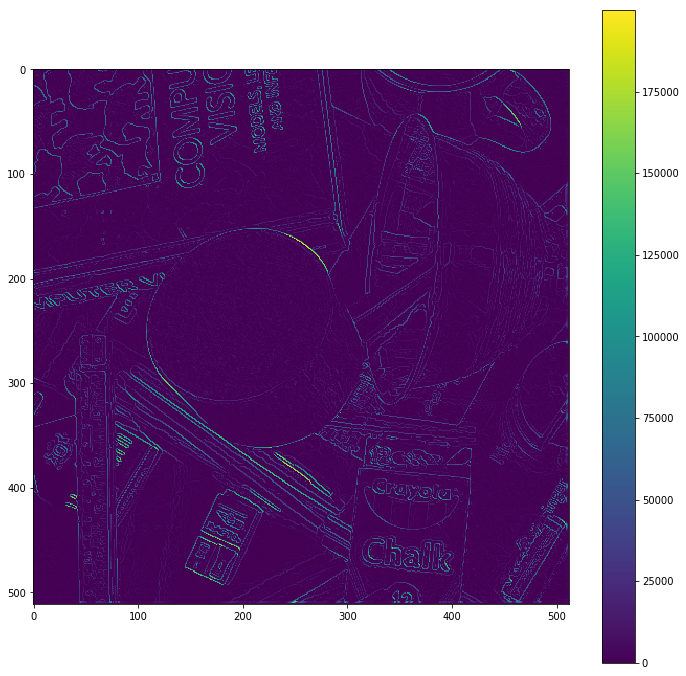

In [98]:
G = canny_edge(im)
print(G.shape)
fig = figure(0, (12,12))
imshow(G*255)
colorbar()

In [102]:
for row in range(G.shape[0]):
    for col in range(G.shape[1]):
        if G[row][col]>0:
            print(G[row][col])

27.341462205879733
28.79043050891896
19.379255804998234
5.0771820705759225
26.687491868330774
38.204130085051766
28.209533455514364
9.15302014516398
7.333333333333343
14.643921757659
23.935097428021585
26.87419249432854
20.488479147505718
24.801433650317808
62.68084945889678
115.27455149434421
210.3547268570667
311.13341189914024
303.16588784946697
160.76622088541419
40.61745656460752
17.694945919982683
19.692073983655924
27.84879809894054
35.301872786329966
45.338235029118145
50.99019513592786
52.272788757100436
50.46671070011287
41.891393971660655
26.60409325231318
18.879736344675024
107.4812645172275
289.0205682799909
273.0181109173691
113.75314403469378
32.348793554697544
30.528675044947438
29.24228293261507
37.70352179247388
12.944325225965017
18.043158136965932
16.89838914084877
15.951314818673746
18.838494867926407
29.522119767312667
36.47221164423984
29.948103260288296
19.0729593345601
11.785113019775782
19.396448701301562
23.795424396766244
29.139511168019098
42.58586098173369

12.01850425154656
12.692955176439822
14.429907214608948
11.392004993756716
15.231546211727817
18.666666666666686
18.110770276274835
17.08800749063506
14.560219778561036
16.492422502470642
20.40697048668532
21.705094128132977
19.938795238317574
14.621141466307554
13.872434697789863
8.60232526704264
6.699917080747236
8.39311887467611
9.54521404218423
9.055385138137428
9.71825315807556
11.785113019775796
9.261629326299857
6.56590520119736
4.642796092394696
9.718253158075495
9.29755045398758
3.8873012632302086
4.242640687119265
7.453559924999256
7.557189365836389
11.794537341969393
12.046207333061721
13.148721948877318
11.935009193312128
3.4318767136623425
7.601169500660905
6.411794687223772
10.760008261045995
28.67441755680874
29.529646120466765
24.449494427856244
18.135294011647236
7.774602526460405
17.669811040931414
129.10805121637034
315.245935739067
441.5520606023963
410.0189697508586
243.6983563524565
73.73526218091914
8.232726023485727
27.018512172212542
32.33505150074063
37.668141

54.560873241626986
36.08631627393168
15.56349003990501
4.71404520791027
35.839146815241584
135.61055350606836
290.89020456369985
410.8865753194886
418.3897704294406
324.96769070170654
184.6185256143056
62.02508453126944
5.3748384988657065
12.292725943057121
15.092308563562362
12.018504251546666
10.077477638554017
6.749485577105531
12.97005097222917
9.055385138137417
15.670212364724236
20.027758514399775
17.91957340762089
18.879736344675088
17.28840330651995
17.294829028097112
17.74510887227491
19.938795238317617
22.647050335284
21.343747458109473
11.897712198383124
7.902179727419807
6.411794687223819
5.333333333333343
3.431876713662326
3.1622776601684603
10.154364141151886
6.128258770283485
19.821424996424632
25.750943887770546
22.23610677354388
14.460674642322667
11.205157542647703
14.98147003616291
16.234394215847853
11.813363431112803
11.556623882239824
11.411495179082419
14.802402207449669
20.15495527710795
25.45584412271571
21.343747458109462
19.18911728616568
15.62049935181333
16

6.798692684790414
10.0
5.099019513592788
16.090024514862915
16.666666666666718
21.317702607092713
37.94733192202051
89.82080926922103
162.6482229981147
208.96836549530119
231.0868042773345
219.9156403916941
158.5840120847272
70.39255011086833
70.77507408057666
206.10730754202345
328.6389440640832
296.9882152544104
160.04721525572103
72.0308575850964
31.343969825860317
15.58489297008122
42.54409477236531
52.942316618078664
69.76946164173675
148.1860692207979
266.14323628869886
239.49576660605558
77.29884288339063
42.90040144852314
298.50665356440925
339.194470604827
48.66438350808755
342.1045973902654
186.5052873840906
21.213203435596412
17.518244457961192
10.434983894999018
10.540925533894637
12.292725943057189
6.411794687223721
8.232726023485643
1.9999999999999858
3.3993463423951917
8.110350040397654
4.6666666666667
13.207741837439263
7.318166133366708
14.313940369055933
6.616477747093085
8.232726023485624
8.027729719194848
26.541372316525873
83.72043425061243
143.19295451321003
206.3

19.51637489107259
19.607254893136943
14.757295747452456
9.153020145164028
20.933757957476782
31.608718909679197
28.476110845564715
13.341664064126348
12.823589374447584
5.374838498865682
12.07384685084989
14.681810363696846
16.739839372652924
13.678856352455488
8.11035004039762
3.1622776601683746
12.666666666666657
9.475113602367871
10.540925533894551
14.337208778404364
14.643921757659193
6.863753427324645
13.349989596333865
10.38160766826495
12.684198393626987
28.07133769523636
25.772509040103618
5.676462121975499
59.58560601726263
89.76141214971561
278.36107646165055
130.49052754042256
12.692955176439803
87.94569031194446
243.7599000838507
320.3126944443854
109.98282694231052
86.53836657164783
92.43616415908033
157.77973394718487
189.52337879826624
115.83992786983634
31.418324447861814
13.928388277184146
10.295630140986916
8.537498983243788
14.337208778404342
15.613384571507172
18.714225130157644
20.275875100994007
16.86548085423127
13.767917618708971
8.4983658559881
2.53859103528792

17.00326765980919
16.719914938645942
11.125546178852483
6.666666666666686
7.453559924999326
6.036923425424904
8.0
5.517648452415645
14.802402207449678
7.0079320138761965
195.2940802425352
417.66866187339355
401.8327457482224
391.4764076898859
209.57152054184803
256.3612901962992
507.46275178031
247.987902930768
231.18054512532942
402.8901146025358
380.15786194684966
160.90024514862893
291.6759998506715
493.7376721386458
176.52761823578774
34.176014981270136
42.37399621885518
205.5431828108147
476.76805448538363
302.3511571372305
47.64918094201031
124.23812261585044
131.00042408752384
179.50549357115008
307.17674969885906
423.27401159165066
476.5218894354288
453.36691052121967
361.5242423099422
255.45993380132586
213.13011153857278
79.08504564356299
28.63564212655272
14.552586635295413
8.768630958643941
3.33333333333336
7.673909622147579
24.94883653488565
19.487887976324668
20.35245002996506
5.374838498865719
4.8534065928536805
5.374838498865643
14.757295747452474
4.268749491621869
7.00

156.16017418023065
411.8233170237505
286.180207406297
11.411495179082438
48.3321838943783
98.34180754445747
156.113918519636
222.52740155864956
291.0708199428831
352.6298027362092
390.41061005618735
367.58702673274826
302.08902293492514
130.04272802087436
9.006170724070865
10.593499054713824
10.0
2.981423969999741
17.139946842909893
20.661289623082293
22.176063171306474
166.94975957521538
391.367119495522
349.20894732078233
284.0696315264192
390.4481755339341
386.29004646767703
158.20169966779054
11.205157542647747
7.803133273813093
15.62049935181328
16.71991493864596
188.97677693891978
436.5216044036207
270.4929656099109
52.925524193068725
45.96133640838182
222.25610852747732
397.44126050972056
361.97636509707206
255.6047295684838
267.1537218739636
361.23553412020686
351.61374009304905
181.94626801461038
23.687784005919845
114.08573773945429
373.55291161732066
404.66721581511337
100.85082492914415
18.820792284657443
17.751369274259122
14.757295747452401
23.781411975649284
21.751117468

206.39821273989315
328.3263958657942
211.27812107372705
83.27998292240189
34.76907949441411
20.292308340299176
14.368174708168226
5.754225500544039
4.055175020198882
9.153020145163964
14.794894014114758
8.069145624606843
19.6920739836559
6.146362971528584
20.275875100994064
20.709632756012052
129.50504065693946
405.57914695462887
224.19436012333392
255.61124996977568
334.83561472592623
61.68918507773915
31.64033993355812
5.077182070575946
7.086763875156492
7.6011695006609585
5.270462766947331
6.548960901462848
5.830951894845293
7.318166133366715
9.533566430716718
23.118054512532957
6.798692684790408
12.481096817899346
278.18658806236107
384.86390090812904
145.82790466086314
34.114187338668614
148.49541706358784
233.82899734635131
276.06158733152273
238.89793264535015
180.85291752630857
128.40214605337047
75.09401514841986
30.782390348307203
12.01850425154646
52.565303300857195
89.34452666193066
130.08117123977289
183.76131862343118
247.4730063843103
308.1940225824563
362.8167581576132


291.8557482349419
283.4211628576023
281.0156183876222
284.0007824715355
287.6900338134006
289.8129665069448
287.28692587338145
279.14950195987177
282.5668062600418
290.38288899696244
268.1773873970568
208.8768909083903
129.3213052826177
42.33464564895067
3.681787005729105
7.37864787372624
2.748737083745092
4.34613493680174
5.374838498865683
6.036923425424961
2.981423969999728
114.28716268923453
339.80451896805477
291.03989799033087
89.87151322242708
6.000000000000028
21.989896669960824
11.642832797715288
26.87419249432846
42.16370213557836
9.067647005823625
30.12566274051999
15.347819244295213
27.62446580680085
5.333333333333314
22.454893057465704
10.842303978193735
22.57333727111604
14.981470036162861
39.13793272233198
31.01970699768489
15.412837362262522
30.814859330452197
4.34613493680177
14.552586635295409
2.1081851067789525
4.055175020198789
3.3333333333333655
6.342099196813487
74.50577904505873
277.04512267859906
308.91063072962993
168.40493526682116
284.6194340206273
343.7964514

8.246211251235321
8.137703743822415
10.413666234542095
6.749485577105558
35.568400457584694
24.335616331258606
18.20866704499684
31.216092715848394
25.99572614446029
31.640339933558067
31.287200080686134
23.612614331233104
48.499713630311454
32.173142698703046
7.195677714974237
26.570660511172882
35.733582088686376
14.560219778561049
10.760008261045956
20.763215336529882
132.0471296334928
274.6007202385958
327.0623453988211
302.9473735009286
236.53846292821902
149.52740365713714
73.15888341289948
25.965789458867217
1.943650631615109
6.289320754704408
3.299831645537205
1.4907119849999149
12.119772641798546
14.267289706021813
16.445195178058704
18.33636338596673
13.349989596333838
11.352924243950955
4.71404520791031
5.6764621219754865
11.401754250991345
25.2366576409969
9.718253158075534
10.022197585581912
12.000000000000014
8.055363982396397
3.800584750330477
2.000000000000014
4.346134936801733
11.64283279771534
14.75729574745243
4.6427960923947085
10.749676997731381
13.283239230114164


8.013876853447625
9.53356643071672
19.470775822013568
82.86669348350337
462.80545468791627
601.7908459109545
162.82505949638096
80.22745443078973
26.973237765525223
39.137932722331904
39.66806720216597
24.413111231467404
7.133644853010871
30.64129385141706
53.92999577641781
37.31547191775074
54.37728283841417
101.51299862031901
94.02718283087673
73.16495821847448
65.49978795555162
69.68660001910142
73.73978271974742
51.22499389946274
78.79368276990516
146.47335745603854
136.05554421305698
62.40548408949687
143.14716592063957
83.06356334492014
60.378436180109475
146.50293891629306
173.23907693640538
140.58449416631981
49.97110276060667
97.7081823026551
31.001792062897152
314.3105329305894
333.03486637621324
50.08881001669822
13.131810402394796
6.200358412579419
5.3748384988656275
8.110350040397632
8.969082698049075
4.47213595499958
4.807401700618663
10.770329614269007
10.770329614269007
10.0
7.615773105863909
4.47213595499958
3.800584750330448
3.01846171271247
49.55356249106171
57.65221

12.481096817899363
6.565905201197393
8.498365855987977
9.10433352249842
7.7316090031621325
12.649110640673518
13.498971154211063
10.295630140986994
13.416407864998723
13.232955494186141
9.672412085697902
6.749485577105513
7.211102550927988
6.200358412579429
4.714045207910329
7.211102550927988
9.718253158075509
8.666666666666654
27.333333333333336
49.33558553417602
82.73787255879591
86.78197457485692
48.82622246293481
14.907119849998603
8.393118874676114
9.067647005823629
9.545214042184236
4.447221354708774
7.1336448530108925
7.902179727419801
11.642832797715329
21.730674684008836
29.529646120466808
25.05549396395485
21.974732965132688
17.26267650163207
10.687479694587593
7.4535599249992925
9.718253158075491
19.067132861433457
13.67073110293991
5.754225500544024
9.067647005823636
16.552945357246855
18.439088914585774
22.40039682188193
22.2361067735439
20.027758514399714
15.90248058916874
12.94432522596508
9.944289260117538
14.337208778404369
15.092308563562371
11.40175425099138
12.82358

588.6392972119872
332.5925101047493
121.50537253782463
64.75423624065925
18.336363385966767
28.79043050891888
61.262640419027846
100.86404490974748
111.5327555274932
71.44539484420564
3.681787005729076
33.56254526171161
18.932629094883854
22.886191858362526
19.39644870130151
6.411794687223759
78.53378607679346
109.46739748030505
82.03657720797472
83.11304216413795
101.98039027185561
105.63669396147871
72.80109889280514
29.032548783888885
42.21637386396686
40.933550488023386
67.02072647903616
5.077182070575892
4.7375568011839295
15.441646429200622
92.20749547744055
38.96722269349512
192.67128022157897
447.23794313293433
423.9415578171648
201.58097352897394
40.05551702879948
9.261629326299875
4.346134936801762
5.374838498865715
1.943650631615098
2.981423969999741
17.44833643773653
22.88619185836251
15.670212364724208
12.018504251546624
13.678856352455472
13.800161029656326
9.910712498212328
15.441646429200636
16.5260736749874
14.981470036162827
10.994948334980428
13.960261060914608
13.48

8.013876853447531
32.335051500740754
124.00716825158851
112.38821606872808
43.01162633521313
12.806248474865704
8.48528137423854
10.852547064066464
6.548960901462837
2.7487370837450746
6.798692684790369
6.565905201197429
8.232726023485663
5.374838498865694
5.754225500544039
7.007932013876171
19.888578520235075
20.138409955990944
17.074997966487608
17.543596489254398
8.666666666666677
4.737556801183996
19.235384061671358
20.76321533652989
7.453559924999288
3.887301263230206
13.864422895390287
38.99002721494588
55.87684871413403
40.47770305297031
23.645530467957602
14.015864027752455
5.830951894845308
4.346134936801767
2.8674417556809026
7.673909622147551
9.055385138137403
4.346134936801736
9.718253158075457
16.719914938645953
8.110350040397638
3.431876713662355
6.000000000000014
5.206833117271089
5.270462766947295
9.999999999999947
15.092308563562362
20.466775244011686
26.352313834736524
26.465910988372254
31.016124838541632
34.848880103160305
58.54722690083429
71.25852775477313
70.3167

1.0540925533894583
5.962847939999469
12.26557966198272
18.59510090797518
15.698549119088856
15.60626654762613
29.683515814524192
36.080157673959505
30.814859330452208
21.333333333333314
15.549205052920797
11.794537341969393
8.944271909999165
12.762793146051068
13.703203194062898
18.390818965511617
25.144029554194812
15.755069730795318
12.525529485370631
8.498365855987975
2.0
2.538591035287997
13.800161029656275
24.810392087904503
18.767584347012324
3.681787005729095
9.545214042184233
5.696002496878327
9.104333522498457
7.071067811865528
8.944271909999152
21.689731313329954
31.44660377352201
25.841396591085704
11.352924243950985
7.8457348639598825
7.60116950066096
11.035296904831254
9.70681318570735
7.071067811865509
10.842303978193705
7.673909622147564
100.33831659828554
173.57547189751332
403.9617693682301
119.36498649101418
75.24773898411982
226.74998468700178
426.8603726955429
272.32415325204715
7.180219742845998
29.31059724930746
13.743685418725532
96.4526366208364
146.081408049682

6.200358412579408
4.05517502019883
7.902179727419801
6.036923425424947
11.897712198383173
8.498365855987997
25.96578945886728
22.84731931759172
8.232726023485668
9.153020145163968
17.139946842909897
13.399834161494518
7.378647873726226
16.34353422950835
27.848798098940563
31.333333333333314
33.13608305156178
36.89323936863114
29.76948474902146
15.6985491190888
5.830951894845288
3.431876713662355
9.94428926011754
7.845734863959938
11.642832797715384
7.8457348639598825
7.007932013876171
43.92164740889297
196.93710219819482
400.300442723268
479.66770905608297
286.4060831135478
100.70970382462878
455.34065391870206
575.8751793767658
417.41852165688846
157.66772374557547
19.821424996424724
18.979521127315707
19.002923751652304
9.428090415820611
5.676462121975474
7.673909622147563
9.706813185707372
10.295630140987006
12.08304597359459
11.401754250991392
10.934146311237832
9.392668535736926
6.749485577105533
0.6666666666666998
7.601169500660925
8.944271909999165
2.357022603955175
18.214768123

6.7986926847903835
2.8674417556808613
3.018461712712497
4.346134936801735
5.4974741674901875
14.794894014114782
7.211102550927986
59.41380311005184
202.10998106091753
488.5261280400239
261.4697773059909
17.69494591998269
182.94018451699213
468.7185841324314
284.72872079304614
12.944325225965088
15.811388300841884
6.128258770283367
21.42687823998426
3.333333333333374
10.17622501498249
2.1081851067789033
10.088497300281041
14.522013940527996
15.613384571507261
16.336734339790485
17.69494591998264
16.66666666666663
10.088497300281022
17.441967269268204
40.77308480412594
362.63970488014075
440.4522927880184
141.67254889748799
37.865258189767815
309.64136961617027
449.7633945877667
142.7826631243755
31.001792062897117
8.353309390761128
16.02775370689511
34.87437773240149
27.784887978899608
11.205157542647761
11.671427600007735
13.57284871433493
39.679269706541284
29.340908112887174
7.453559924999291
8.110350040397648
8.110350040397632
11.822765233978798
24.877477542727032
17.081503967091923

358.200440473704
352.54912975199477
242.83739415501893
121.04728185483742
55.95434647003649
27.588242262078076
27.247833756914428
168.51574275288215
349.7684948648177
266.0542968810857
92.98625943893244
40.094333210013126
13.605554421305655
21.63330765278388
35.10302297840203
62.10564476044925
57.13337222869154
57.62908216439956
18.439088914585753
214.6708074134803
395.2861129752866
206.42243633438255
11.66190378969057
1.6996731711975848
19.977765418362235
6.749485577105511
12.82358937444759
16.124515496597105
13.097921802925685
8.393118874676167
5.099019513592807
5.099019513592771
6.699917080747248
3.5901098714229884
6.128258770283439
5.696002496878368
6.6666666666666625
13.703203194062954
14.794894014114789
13.507199726236518
7.007932013876213
15.506271132817357
181.9218391385585
361.95272865082495
268.74688628687187
96.38464608017193
48.38962239525702
39.51089863709898
17.820088539498176
28.284271247461874
26.272080660317485
16.254913786982197
23.856049780110464
88.51992870409342
41

15.620499351813269
18.979521127315667
13.743685418725557
22.39543604298777
18.01234144814173
6.798692684790398
18.04315813696579
5.754225500544
12.44543646839631
6.666666666666671
9.392668535736908
12.866839377079158
7.774602526460395
5.8309518948452785
5.65685424949237
6.599663291074441
7.318166133366713
2.0000000000000284
39.849717690342544
249.12468988663306
299.93369637675295
88.6002257333468
23.80009337049859
36.37459430854325
26.832815729997503
25.29822128134706
18.5951009079751
6.20035841257947
24.189070075369056
25.019992006393636
10.154364141151852
16.739839372652977
8.48528137423859
7.8031332738130885
5.676462121975341
16.845705024657637
24.89087293679257
29.612309752683775
30.78239034830718
34.57037909990432
7.071067811865439
25.20141089524776
42.04759208325733
51.0707570163417
41.228361327825965
32.693866227304575
24.5130350811336
22.010098692292257
16.739839372652913
21.31770260709259
28.134597128012256
66.60330322138691
147.85052511837011
258.6189818589845
324.45407139446

9.809292646374736
13.727506854649329
19.22960680247458
18.785337071473865
16.25491378698211
13.333333333333371
10.121484300459281
7.195677714974305
7.211102550927978
8.602325267042627
6.0
5.0990195135927845
1.4142135623730951
8.602325267042627
8.94427190999916
1.4142135623730951
4.0
4.47213595499958
5.830951894845301
2.0
4.242640687119285
4.47213595499958
7.615773105863909
2.0
2.8284271247461903
4.7140452079102735
0.6666666666667425
5.676462121975431
2.0
4.027681991198141
10.593499054713734
5.011098792790937
4.472135954999592
4.447221354708766
1.333333333333286
1.9436506316151407
2.8284271247461903
5.656854249492381
6.128258770283407
3.590109871422941
2.1081851067788984
1.3333333333333144
19.48788797632461
236.55396377524045
332.2114453844787
126.52711610999083
12.692955176439867
13.70320319406294
8.069145624606755
5.270462766947323
12.45436112817961
7.673909622147576
10.121484300459331
12.875471943885326
10.540925533894594
3.2998316455372656
8.498365855987943
9.261629326299877
12.2927

8.94427190999916
9.29755045398758
9.285592184789387
10.295630140986978
9.533566430716652
14.621141466307499
8.05536398239633
8.069145624606753
16.666666666666682
12.762793146051141
3.431876713662431
6.146362971528662
4.714045207910335
12.944325225965105
7.601169500660909
7.601169500660914
23.570226039551606
17.20465053408527
8.432740427115693
8.666666666666686
20.741798914805422
20.4667752440117
26.985592864012155
25.51252415753662
30.07028803025043
26.26362080478962
22.983085567917602
76.53176537302082
93.09732064410402
34.570379099904514
55.33734925185906
33.33333333333334
13.399834161494534
33.99346342395196
54.49566751382882
27.137509916063475
53.14132102234565
17.950549357114966
21.79194550490817
21.296843793284346
27.37801226450807
59.97962617052186
77.49982078832323
66.69499398172421
232.95683911164502
63.420991968134906
345.9046111285596
182.5893997166563
13.1993265821489
9.672412085697928
14.794894014114831
6.200358412579459
5.6764621219754545
5.011098792790974
3.5901098714230

80.44597911366088
66.02693053259077
49.694623004461505
40.9769582950115
45.49969474867083
74.40728757618065
96.81368131048885
39.129414908877806
28.491714195144144
36.69090108217869
16.0277537068951
8.666666666666554
4.055175020198806
0.9428090415821303
7.61577310586399
17.34614910834362
23.404652908722607
24.189070075369056
55.63372278673356
103.71327998113085
114.7945023848171
124.60247901939101
122.1520000291076
139.0675295594834
87.92926450025357
36.81787005729092
29.702225879927326
19.999999999999936
10.413666234542239
31.839877163358807
56.93856338194702
87.66856778673751
89.8195722298629
107.53087411943093
59.1532848716882
48.33448274495369
176.83953806268053
193.00316635284054
70.08724721532596
13.408123574079196
56.11496136405055
52.952809179494885
24.51303508113366
6.324555320336858
16.013882865952446
11.595018087284062
11.709445380166855
9.71825315807552
0.6666666666666572
14.802402207449726
46.678569910494176
29.72840018867106
43.26918328582388
38.94725778394271
4.807401700

304.4966702974308
454.136543343519
148.12907284602244
106.44351658143496
34.90304030055581
30.360793431295203
40.477703052970334
107.67027857718627
56.682350770666595
26.386023236217767
24.166091947189162
9.428090415820636
4.346134936801716
4.027681991198197
2.357022603955153
1.4907119849998514
7.557189365836427
8.602325267042671
5.9066817155564495
10.154364141151879
8.48528137423854
6.289320754704389
2.981423969999741
9.706813185707382
11.671427600007792
6.548960901462854
4.242640687119275
6.146362971528597
14.802402207449669
6.411794687223793
5.999999999999986
6.960204339273696
5.0990195135927765
3.399346342395206
3.431876713662322
8.013876853447554
8.055363982396381
4.346134936801799
26.503668509178972
21.628170930011063
209.58477468026578
253.90505662112713
109.18892902772801
23.53720459187964
2.1081851067789708
12.292725943057174
20.466775244011604
72.4077957742734
89.56685895029608
26.149144876606954
5.374838498865698
10.413666234542232
6.128258770283385
12.165525060596444
10.540

13.207741837439299
2.0
16.282232989093092
10.63537075569591
11.813363431112917
11.671427600007705
8.23272602348561
10.540925533894587
6.324555320336777
5.206833117271119
11.822765233978785
10.687479694587632
11.479450238481725
8.393118874676107
7.453559924999289
7.071067811865449
2.538591035287991
7.845734863959877
1.0540925533894583
4.737556801183971
7.007932013876247
12.238373167123891
3.3333333333333113
5.4974741674902186
10.198039027185557
2.82842712474617
16.505891204186625
25.88865045193015
27.828841952989084
26.541372316525848
31.471327338459105
37.13339317768971
38.3347825813002
35.839146815241634
33.09917756615041
31.752515210959597
29.604804414899323
29.306806187111007
22.983085567917602
19.258475767539117
12.55211358917519
13.87243469778994
9.067647005823689
4.737556801183947
4.666666666666657
1.0540925533894627
9.80929264637477
4.0
9.706813185707386
17.262676501632093
7.673909622147536
7.54247233265646
11.671427600007735
14.39135542994859
59.91289974250581
44.6069252221869


12.16552506059643
10.022197585581898
6.960204339273706
11.035296904831235
10.077477638553955
6.128258770283386
1.0540925533894538
4.268749491621861
7.673909622147541
3.4318767136623345
19.977765418362246
25.612496949731423
17.669811040931403
14.636332266733417
16.666666666666664
8.027729719194861
4.921607686744484
3.0184617127124715
10.687479694587577
13.507199726236529
8.027729719194879
6.036923425424943
7.0710678118654595
9.3926685357369
13.038404810405305
18.648800974265804
19.102065042525876
9.809292646374791
6.289320754704396
5.270462766947215
4.807401700618675
5.333333333333329
9.672412085697916
9.486832980505097
5.2068331172710565
5.676462121975457
10.121484300459281
13.743685418725498
10.295630140987
5.2068331172711275
3.431876713662362
4.027681991198215
2.9814239699997027
5.676462121975465
6.1463629715285535
8.768630958643902
19.533447098644782
28.007935383466638
24.60803843372236
2.82842712474617
9.428090415820632
6.565905201197386
6.863753427324659
6.3420991968134794
16.3639

6.2003584125794
7.615773105863845
0.6666666666667282
13.399834161494612
13.498971154211082
11.671427600007762
8.956685895029585
4.268749491621891
8.027729719194898
7.5424723326564695
3.431876713662336
6.036923425424943
5.374838498865696
9.055385138137382
5.517648452415619
4.807401700618604
5.0771820705759225
6.6666666666666625
15.34781924429513
13.743685418725535
8.339997335464576
8.232726023485654
9.104333522498479
19.436506316151004
21.317702607092624
16.67999467092909
14.884742374510783
14.75729574745246
6.411794687223779
14.251705550954595
10.00000000000001
10.883218478209695
8.53749898324379
3.6817870057290807
5.754225500543986
6.411794687223751
12.165525060596423
24.230375793848335
25.214634198769932
16.99673171197594
10.883218478209644
12.018504251546647
5.374838498865698
4.807401700618596
11.352924243950893
16.89838914084877
13.767917618708884
8.246211251235335
13.9204086785474
25.26745821099637
26.26362080478962
24.988886418655063
21.68973131332984
25.647178748895097
25.551690

74.38787236879111
218.61178172987638
127.27922061357856
7.318166133366722
7.007932013876197
17.029386365926413
126.64298024148212
132.33375314794873
156.06978496101598
125.64942410444141
2.8284271247462303
11.005049346146096
10.852547064066492
8.39311887467608
8.498365855988
12.018504251546634
2.4037008503093436
5.270462766947315
5.906681715556425
3.399346342395128
5.734883511361721
11.125546178852424
7.673909622147522
9.428090415820641
11.401754250991337
8.339997335464531
4.346134936801743
8.110350040397638
12.454361128179663
18.390818965511617
12.866839377079158
11.595018087284094
11.935009193312109
5.099019513592788
7.363574011458184
4.216370213557824
9.486832980505124
9.428090415820614
7.731609003162152
19.189117286165676
38.07886552931952
18.55322673343432
11.794537341969447
4.71404520791034
19.737161790783244
15.563490039905034
15.951314818673898
10.413666234542228
8.137703743822486
11.785113019775855
15.58489297008129
14.015864027752436
11.66190378969061
7.133644853010866
2.1081

10.381607668264994
15.811388300841896
14.015864027752412
2.538591035287956
5.830951894845288
12.736648783028535
7.6739096221475345
7.378647873726253
5.696002496878377
6.342099196813507
3.3993463423952113
1.8856180831641502
12.018504251546604
22.010098692292253
17.919573407620863
9.153020145164023
7.774602526460424
8.11035004039763
18.067773643823525
27.00205753477149
53.46026561849465
39.93606000707747
35.508997294895444
11.67142760000775
11.469767022723522
12.525529485370637
7.086763875156432
4.71404520791029
0.6666666666666714
10.12148430045934
14.149990184527425
2.82842712474618
11.78511301977577
16.739839372652963
41.325268030319876
32.63604006479821
23.323807579381256
19.37925580499816
10.934146311237786
7.0867638751564135
7.211102550927967
14.1499901845274
19.5163748910726
7.8031332738131205
10.46687897873837
14.368174708168198
11.785113019775805
8.956685895029626
6.749485577105489
6.324555320336718
10.466878978738329
12.970050972229133
11.333333333333332
12.525529485370615
15.03

7.453559924999288
12.94432522596506
91.64181481301112
84.11764248823064
45.93957383829811
64.88622521169052
22.35571018280965
7.453559924999301
42.342518688534454
58.74615826682727
36.51787994333126
19.888578520235086
28.03172805550481
27.43072081525463
26.997942308422118
2.82842712474618
1.4142135623731051
9.153020145163977
56.25339495927729
80.51638894590899
27.198856185100407
11.785113019775732
9.006170724070893
2.666666666666657
20.292308340299204
21.213203435596366
9.910712498212286
37.24394059590247
76.36898730651222
5.676462121975443
7.086763875156396
2.357022603955175
7.133644853010911
1.6996731711976154
13.727506854649315
12.337837015547798
9.055385138137419
10.466878978738398
0.9428090415820499
3.3333333333333144
5.830951894845301
6.749485577105514
15.355057075041346
9.988882709181103
4.34613493680176
8.232726023485595
14.212670403551913
6.342099196813449
6.000000000000014
1.6996731711975848
3.6817870057290922
8.944271909999197
11.392004993756712
10.59349905471377
11.12554617

1.943650631615092
0.4714045207910853
3.681787005729055
7.453559924999282
9.055385138137419
5.696002496878379
5.830951894845315
10.540925533894526
9.475113602367955
9.055385138137414
9.706813185707372
10.413666234542218
13.308309851784761
8.232726023485638
2.4037008503093866
8.393118874676071
8.339997335464579
8.013876853447506
26.570660511172782
34.5960819875443
21.705094128132917
17.938165396098288
18.767584347012335
16.0
5.011098792790999
33.33999933346659
28.662790435607597
17.745108872274933
16.090024514862932
20.53722906766581
46.05310943778809
34.528571100209525
19.787762772874444
14.149990184527416
18.553226733434308
9.067647005823682
20.396078054371117
6.1463629715285535
9.357112565078776
55.78729445153456
20.537229067665816
79.67294257009578
50.03998401278727
21.929178937864698
38.37823457233137
47.07440918375932
58.940648113165516
57.37401657351329
20.87529108246826
106.18746525733526
69.40060838670252
45.294100670568035
74.90735018081412
65.24483802484983
53.651136469271954


193.6462984125668
167.86237749352225
147.48408577048417
135.78496071198586
127.90621564255586
119.69776754624768
110.8672880319327
91.07994046745723
78.36382385315868
88.66917289691054
108.53058964590988
110.0272693471941
98.81520350859186
88.66541352497899
75.46154281781176
65.65228268858762
70.20604595680408
76.4852927038918
65.6742804384724
21.83778580554562
15.180396715647573
16.027753706895137
87.39692341394073
54.903956546358685
75.26693238807535
144.25671561490645
185.14738873544923
198.85561484543388
87.10785141293398
18.0123414481417
28.538473057338628
23.026554718894037
3.5901098714230573
16.343534229508364
17.499206331208974
10.154364141151865
10.540925533894592
14.90711984999861
26.008545604174838
12.229290885229423
2.82842712474618
0.6666666666666572
10.0
3.887301263230213
8.602325267042627
10.88321847820965
4.737556801183958
7.0710678118654755
2.0097183471152322e-14
5.754225500544058
3.7712361663282703
8.232726023485665
2.981423969999728
8.232726023485638
11.8227652339788

8.110350040397684
5.517648452415646
11.125546178852414
17.69494591998268
12.018504251546606
19.43650631615101
36.15399163455003
40.334710720282715
40.75400457487443
69.58448102845917
198.78743532840411
293.4037794197235
115.88883562372271
78.64547737226285
134.83899864488598
169.94182010977235
156.20499351813305
134.86618882762608
100.70198056090501
48.898988855712645
38.13426572286695
78.59035847000858
123.48999059752887
126.4076298681725
103.04368005850722
91.12872458475672
66.8563966855661
51.0533490032186
39.485581053228884
29.81423969999724
17.543596489254373
20.92313976863357
29.42787793912432
32.43112359721406
39.15212496006938
64.54800108790697
65.86180818788515
44.13363544710287
47.149879226898435
44.56206657884905
50.21951811795888
60.120249870109824
58.034472514187634
62.03224967708329
71.74801584558126
68.02777210652852
54.0
52.078999819718305
54.20127099780747
69.35416353759881
73.04488726499305
58.47126549758335
41.69998667732278
31.692971530679227
31.80496117833757
25.77

13.670731102939909
10.413666234542204
8.498365855987986
18.85618083164124
13.482498944104497
1.6996731711975985
14.12641340027812
30.203016773531534
62.781809113433056
66.57326790837301
26.305892875931814
12.018504251546634
201.8057371720525
590.9008189009198
744.0843739493229
448.1827504241744
158.76257605479813
148.02402207449674
227.53412442483827
202.25506448816333
122.24747213928164
137.01986879443595
86.9252552484029
26.87419249432849
120.0333287049893
53.76905347047791
66.1647774709307
117.4317768843775
219.77008187851433
224.64292653997467
151.6443206981389
56.12090123613083
30.236107921196197
19.189117286165676
24.841721178515616
28.067379246694504
19.556186858496815
16.12451549659708
22.28103328942453
23.041026211713937
26.436506745197825
23.56079606276306
17.71377367411524
23.837412238374835
37.73886885191743
51.01851515762575
81.42754106839062
106.7967956240053
92.0676080087044
52.26003359270936
23.897931105246574
174.15446528234003
394.38785196526754
299.875900258016
73.44

3.333333333333326
8.768630958643973
1.9436506316151652
14.063348739819272
7.601169500660902
15.180396715647582
8.94427190999916
6.342099196813492
11.50845100108807
18.773503787104957
9.533566430716812
24.244128727957598
8.055363982396408
12.806248474865697
14.907119849998603
16.666666666666657
12.373807462180386
15.412837362262554
5.270462766947305
11.40175425099138
23.53720459187964
19.235384061671343
1.4142135623730951
2.9814239699997156
17.44833643773659
16.09002451486293
16.1245154965971
10.413666234542221
13.743685418725523
7.086763875156415
19.888578520235058
18.595100907975
1.0540925533894447
17.91957340762078
13.992061241210346
27.668674625929487
21.68973131332991
11.822765233978833
21.76643695641935
23.64553046795756
4.666666666666629
20.05547860865509
8.06914562460675
13.678856352455366
24.68017648055035
26.79966832298908
19.229606802474738
7.7316090031620766
3.8005847503305055
2.8674417556808085
13.727506854649315
15.84648576533965
15.231546211727817
10.198039027185564
28.28

162.04594684498863
126.11282426638633
74.4102740815331
27.539870087646502
16.44519517805856
32.836294282732545
37.59728122558274
32.338487561693064
15.83947249402234
0.4714045207910853
26.465910988372283
75.96782944846535
56.200039541306865
20.923139768633558
32.550814975289846
47.72607021092107
38.55443482200769
15.67021236472416
10.198039027185569
4.47213595499958
8.537498983243792
12.481096817899338
9.153020145163955
23.418890760333763
24.801433650317744
29.001915645541608
33.469720976163195
14.666666666666714
11.661903789690523
9.297550453987558
12.0
28.75953948016406
24.08318915758459
6.798692684790372
11.794537341969473
15.180396715647602
6.4117946872237725
18.043158136965804
9.055385138137417
16.55294535724685
8.602325267042627
8.246211251235321
14.422205101855956
12.649110640673518
34.66987164671943
15.584892970081277
14.063348739819393
14.90711984999854
9.80929264637482
5.099019513592813
16.3367343397905
14.802402207449672
5.6764621219754545
13.74368541872552
16.73983937265296

5.999999999999986
9.475113602367964
16.02775370689506
23.190036174568124
30.987452657845594
53.56823270890647
90.22687453796065
128.5699118076318
168.15997674172587
210.43552720753
263.3291138902461
327.34249817448256
369.16060943111955
382.11225808363935
386.5149127495314
376.65103212390113
348.38835291158114
309.61660879940604
257.62720698283744
198.9170681465016
133.51737298527436
69.16807227487429
27.194770739161505
14.764823060233528
50.77619739821229
74.42371187255358
98.58217102724238
133.02046626156613
169.9339741062851
192.91679265654625
197.83045490745062
200.52486684254956
199.68030003538718
180.933382461305
147.1386345518327
109.6306931880342
73.67345368433448
51.0206929697266
34.72431104828116
15.670212364724257
10.852547064066519
19.556186858496773
29.12043955712203
37.906317268878695
44.20658573360108
43.15604759989545
40.672130780452484
39.09248293754463
34.412530017745354
27.084230754362444
29.242282932615083
32.82952600598698
26.008545604174795
17.74510887227492
11.04

115.21188210326996
88.04039476916894
72.04936579256693
53.43739847293802
23.645530467957652
20.763215336529914
41.723960608850305
49.94441354590564
54.21356943709864
59.243377501437045
52.93602008294751
39.01281840626232
33.43982987729186
32.045107097478834
20.869967789997965
5.185449728701325
10.121484300459322
9.006170724070866
3.399346342395225
2.3570226039551834
4.714045207910303
5.374838498865699
14.621141466307563
18.012341448141726
14.681810363696803
9.718253158075463
11.469767022723447
22.866763848189947
26.149144876606908
34.2571971351358
42.4918292799399
36.884203182994774
27.100635498903785
18.523258652599793
14.80240220744964
8.856886837057598
23.72527953236571
78.25882981775571
146.57118103880836
210.4899047460472
258.3726851748158
317.2650486755689
389.0347028222547
421.77613862226866
425.9611354206965
445.7208892469717
425.41300194307905
365.23995156913236
290.89326030159043
210.46878892394253
133.14820481119682
57.00682220381855
29.702225879927212
17.081503967092004
50.

38.23029630483596
128.81080009930156
72.30337321161288
70.41622287828602
33.54930037356308
71.08836441750194
14.0633487398193
50.288059108389575
104.44030724666501
52.087533164002934
66.95935749061178
22.09575122556881
46.85912694212074
35.36790761253606
67.23920813863825
42.99870799092559
36.28283953116736
71.70928965079925
52.70462766947293
45.05058884804453
111.3003943289411
37.13339317768966
254.4650161504414
172.7129924984736
144.6290273615762
277.0002005614998
98.83431702714512
142.96231049553663
157.66420012165102
42.85375647996856
153.10490230920468
42.52580915684546
27.90858091857931
53.37498373666161
55.866905329641426
42.28212125447088
51.98504058327208
61.42384625606645
40.138648595974296
24.037008503093226
26.149144876606922
37.63272807307785
124.09763181552748
156.29174997776153
96.89627902499087
64.72677618695033
70.4288451007273
89.40295794261438
128.1153993693013
134.61797799699713
101.80809834629515
70.925626147708
32.62241901242488
22.86676384819
12.046207333061718
1

26.183115848874
26.38602323621772
20.319667538837475
20.747155092793882
21.54065922853796
7.601169500660921
9.718253158075507
13.399834161494502
9.285592184789461
9.357112565078868
10.749676997731395
9.706813185707281
5.69600249687829
1.3333333333333428
6.960204339273637
7.378647873726221
4.0
2.7487370837450955
10.749676997731356
15.67021236472419
9.54521404218419
3.800584750330426
1.88561808316412
2.8674417556808547
4.472135954999503
2.538591035287978
6.036923425424912
12.33783701554787
13.49897115421102
11.785113019775766
5.696002496878353
2.403700850309371
3.681787005729076
6.565905201197413
12.80624847486576
19.977765418362285
19.436506316151014
25.789748178512955
42.62758626888358
53.682192371193054
48.67123266251724
20.70963275601205
34.052247437659
45.97583906551107
16.41814714136635
10.852547064066421
118.73406325809704
88.38426204804662
8.39311887467612
58.471265497583445
103.80537344258993
82.54964836051361
20.05547860865513
47.53945729601886
11.205157542647727
61.33695641472

27.560035478125805
28.709270666845946
31.34042472944846
38.209946349085584
36.135547287647164
40.1801498808112
48.9398724059546
53.6179903473536
63.062579148722534
100.69204977995474
165.91631089866428
213.77142517703862
172.53985046939158
36.81787005729092
127.29056873503582
195.60163598497837
151.0643718566507
90.86375637305676
55.025246730730586
44.56705310228869
44.402202147591225
43.00129197025477
42.55454016775277
34.73390914429929
18.523258652599726
2.9814239699997156
6.749485577105564
10.176225014982471
8.39311887467615
7.8457348639598345
6.960204339273645
5.8309518948453105
8.232726023485574
7.37864787372624
12.970050972229247
25.05549396395486
28.00793538346668
36.35931792539568
48.746509846574874
69.30287792645329
66.82647512608887
59.44371754488062
94.05908308670197
82.60750571225358
16.09002451486295
95.13148795220226
147.9827317253229
74.29819797425925
28.2999803690549
7.378647873726248
3.8005847503304557
44.54460935087677
86.3700050814968
99.8510001062695
61.119191384994

18.950227204735892
14.981470036162861
9.06764700582359
25.368396787253968
21.633307652783937
30.59411708155671
2.8284271247461903
13.703203194062995
47.35210895221268
8.39311887467624
40.180149880811086
10.687479694587614
35.35533905932738
39.468693641641785
32.24903099319419
16.526073674987433
11.3920049937567
1.0540925533894179
5.3748384988656905
0.9428090415821303
1.9999999999999716
4.714045207910302
2.748737083745089
3.1622776601683795
7.211102550927978
12.165525060596439
5.07718207057589
3.018461712712495
4.055175020198812
5.754225500544069
9.428090415820721
9.35711256507878
4.6427960923947165
4.055175020198816
5.374838498865687
13.283239230114132
23.194827009486463
16.786237749352257
18.012341448141726
19.0029237516523
10.088497300281063
16.234394215847935
13.232955494186212
19.516374891072644
10.635370755695835
10.749676997731324
4.268749491621851
8.0
15.391195174153564
16.739839372653023
18.696404883173496
27.784887978899633
33.33333333333337
34.0359287289835
36.0801576739595
4

11.661903789690601
20.591260281974
8.602325267042627
21.633307652783937
22.67156809750927
14.7648230602334
10.198039027185569
12.806248474865697
12.083045973594572
13.92838827718412
4.47213595499958
15.620499351813308
13.92838827718412
18.439088914585774
8.94427190999916
14.560219778561036
0.9428090415820499
16.606558276108142
17.159383568311657
10.121484300459308
8.232726023485638
13.743685418725498
1.3333333333332575
9.35711256507878
8.666666666666629
15.606266547626145
18.384776310850235
8.432740427115684
28.071337695236398
29.397656747132448
3.0184617127123885
17.543596489254348
13.572848714334919
10.077477638553985
8.894442709417527
12.692955176439856
14.757295747452469
15.902480589168777
5.011098792790906
16.825905952165336
7.774602526460353
1.0540925533894447
4.47213595499958
7.0710678118654755
10.770329614269007
6.324555320336759
6.324555320336759
9.055385138137417
20.423298242720502
10.02219758558188
1.0540925533895618
9.988882709181148
1.0540925533894718
14.368174708168215
9.

26.541372316525848
17.543596489254348
19.533447098644825
5.830951894845301
5.0990195135927845
17.029386365926403
3.1622776601683795
18.384776310850235
10.198039027185569
11.661903789690601
37.12142238654117
29.5296461204668
7.615773105863909
23.194827009486403
10.0
21.213203435596427
11.40175425099138
17.88854381999832
31.710495984067414
19.43650631615095
17.081503967091944
8.35330939076116
12.083045973594688
15.20233900132181
8.055363982396408
12.727922061357855
17.950549357114983
10.635370755695792
5.011098792790999
14.313940369055913
22.33582075700135
21.628170930011105
26.149144876606908
12.806248474865697
5.0990195135927845
8.94427190999916
1.4142135623730951
2.8284271247461903
8.48528137423857
1.4142135623730951
10.198039027185569
3.1622776601683795
12.083045973594572
3.1622776601683795
8.602325267042627
4.242640687119285
20.248456731316587
24.698178070456937
22.847319317591726
12.083045973594572
11.661903789690601
11.313708498984761
3.1622776601683795
19.235384061671343
20.24845

15.613384571507169
4.642796092394728
11.661903789690601
13.416407864998739
20.09975124224178
11.661903789690601
14.337208778404353
6.036923425424827
10.883218478209638
12.525529485370622
1.4142135623730951
16.418147141366344
14.757295747452515
6.146362971528584
4.472135954999554
21.343747458109505
8.027729719194896
14.981470036162788
16.97710877099573
21.587033144922895
17.39092994766076
23.645530467957578
10.770329614269018
5.6568542494924
17.262676501632093
18.439088914585795
14.0633487398193
14.181364924121723
4.242640687119285
9.843215373488883
7.3635740114581
12.944325225965022
9.718253158075507
8.602325267042627
7.673909622147523
14.015864027752441
24.14769370169978
20.319667538837578
17.262676501632093
33.10589071449371
24.156894575991274
15.202339001321796
26.00854560417488
16.6599986661331
5.51764845241561
13.349989596333867
10.760008261045964
5.185449728701315
7.453559924999282
13.92838827718412
8.602325267042627
13.038404810405298
5.374838498865687
12.337837015547827
8.35330

25.789748178512955
26.754023581094817
21.9342451684827
22.6666666666667
24.26703296426839
27.247833756914403
29.352266617001785
25.634178572973873
21.296843793284307
26.541372316525745
30.360793431295164
25.342103744997655
51.495415114141785
145.2002448727657
189.6200880122615
102.90988506671474
19.102065042525815
19.82702981061733
33.61547262794325
39.293765408776984
49.59614680373646
44.721359549995796
33.109246778237356
41.163630117428205
38.6494214416953
15.620499351813287
14.522013940527994
11.244751862288673
20.248456731316633
54.397712370200956
91.30413158474512
135.09831810779727
158.69747600037275
140.28700739713716
88.25468196582482
39.24849607876007
5.830951894845374
22.281033289424506
18.773503787105042
16.055459438389683
22.84731931759173
101.30372374421607
160.98102027533832
98.0351410917988
12.33783701554784
13.004272802087483
7.007932013876254
2.7487370837451026
3.800584750330437
4.666666666666671
8.6666666666667
5.20683311727106
5.270462766947306
8.353309390761074
14.1

22.822990358164944
32.22145592958551
50.024438472055245
71.75266158439312
97.11962840858807
101.5666174379052
72.78125521802376
41.05822424043415
31.00179206289713
25.789748178512927
34.82655436429061
33.993463423951894
30.825674724525054
28.771127502720134
22.01009869229224
19.80460103668393
21.730674684008797
16.60655827610819
14.313940369055937
16.124515496597112
14.14213562373097
14.26728970602177
14.636332266733387
17.919573407620764
8.498365855987938
17.888543819998354
32.82952600598707
35.03966006938099
41.59326868617075
37.20215047547658
35.69002350486451
26.098105508084462
18.36058580522717
24.738633753705955
19.62424803938006
12.018504251546657
11.045361017187258
5.099019513592791
3.681787005729132
7.601169500660984
21.270741511391762
30.184617127124756
26.907248094147356
34.4157586643741
51.56441494760597
54.87966634171326
65.86180818788519
73.80003011140616
62.253960159620036
45.03085362035434
27.999999999999915
24.133885813197246
24.35387261014373
34.52535300326413
34.4157

67.09860074712603
70.08724721532599
40.44474969359777
30.782390348307167
13.283239230114201
82.82243389055618
126.15686884016881
44.94441010848851
52.41925006882279
65.89554023014169
65.77064525894346
36.080157673959505
6.200358412579427
24.230375793848353
78.88669793514687
86.90735808255181
100.36488983260584
68.53385213811414
25.267458210996285
3.333333333333337
39.001424475410026
30.73181485764296
26.14914487660687
31.67192938725255
24.08318915758458
20.466775244011682
13.333333333333343
14.621141466307547
28.425340807103755
51.8544972870135
146.35497182459423
143.08738588708647
23.570226039551613
66.94110180682048
49.09175083453431
13.274871834493235
10.38160766826495
12.692955176439845
10.022197585582012
16.679994670929034
18.481221700838777
9.067647005823636
6.565905201197457
10.934146311237868
11.813363431112913
10.666666666666671
2.8284271247462
8.339997335464517
9.428090415820602
5.206833117271129
12.94432522596505
10.349449797506649
8.027729719194875
18.19645875194159
16.3639

70.82058708846992
78.25882981775568
49.04872860511043
22.28103328942451
7.180219742845983
6.2893207547043914
6.342099196813464
6.616477747093014
2.1081851067789077
4.447221354708811
2.1081851067789033
3.999999999999986
6.548960901462809
6.5489609014628645
6.411794687223779
7.363574011458111
5.099019513592826
4.853406592853707
9.006170724070863
14.337208778404344
8.768630958643918
8.232726023485679
11.125546178852428
3.88730126323024
10.666666666666686
14.974051630144157
13.072447700751766
9.54521404218423
7.1956777149743125
5.270462766947309
5.830951894845312
6.200358412579427
2.6666666666666714
16.110727964792783
22.51419305435767
18.648800974265804
13.498971154211091
3.1622776601683524
13.341664064126334
25.64717874889515
37.037518515388925
28.771127502720113
27.984122482420485
46.20004810002303
38.58036345661409
34.615346628659125
7.5424723326565
74.04803245941856
87.53919756949514
41.62264341010124
22.070593809662455
15.297058540778343
83.19855767980599
73.57686834566663
35.8546448

109.87366482566333
114.22006050699778
115.02366906182593
96.42613753542142
43.392267616349486
30.07028803025052
53.53711070110352
69.99999999999997
77.34482673212361
68.47059385036913
50.42265804620424
34.3349514181815
25.412158070061146
21.081851067789167
19.821424996424756
14.181364924121773
3.1622776601683795
8.653836657164828
7.673909622147666
5.206833117271095
3.1622776601683524
5.999999999999972
11.401754250991358
13.416407864998712
8.48528137423855
16.60655827610819
15.463218006324254
6.565905201197385
9.297550453987537
6.3245553203367315
7.071067811865471
4.3461349368017475
4.055175020198845
6.200358412579419
11.205157542647711
11.125546178852375
12.165525060596476
8.3931188746761
47.050799969583686
82.43246393934308
30.360793431295196
272.8552729928451
332.81559792507056
189.32453031178437
104.98042145509275
65.39113089708728
56.28893714083119
42.928881756794986
7.0079320138762595
65.82974673774427
83.27197741270604
62.271805640897995
37.738868851917374
17.950549357115065
12.8

7.453559924999231
17.159383568311657
7.615773105863909
15.69146972791977
9.4398681723376
2.4037008503093316
4.216370213557842
17.029386365926374
6.56590520119735
5.497474167490226
6.863753427324545
10.540925533894601
20.357908646136597
21.234144411510606
16.878651868229515
16.825905952165265
5.906681715556492
21.974732965132706
10.883218478209727
7.557189365836458
10.852547064066517
16.706618781522266
8.246211251235362
20.67741655902784
21.837785805545593
19.419348884839348
10.33870827951392
12.806248474865697
5.656854249492381
5.676462121975457
8.49836585598801
10.295630140986987
6.342099196813516
5.374838498865775
5.51764845241557
14.181364924121748
12.692955176439833
17.788885418835058
36.96244340167762
48.49971363031148
25.56473265175208
41.282226468811295
181.4374700979804
271.6967263533205
95.55917305814
42.77330423939159
26.436506745197782
13.864422895390357
14.522013940528067
27.341462205879832
52.47644974441181
97.22596818180259
137.08391590555033
167.3439571660716
169.0555464

14.621141466307513
9.672412085698015
13.038404810405321
8.0
5.754225500544013
13.308309851784735
14.907119849998587
18.90913947157705
13.743685418725503
17.08800749063506
22.135943621178654
22.847319317591726
18.439088914585774
8.602325267042627
18.384776310850235
16.97056274847714
18.384776310850235
16.1245154965971
10.770329614269007
14.422205101855956
19.849433241279208
7.195677714974271
15.033296378372821
9.899494936611646
12.823589374447584
17.204650534085253
14.142135623730951
28.460498941515414
19.235384061671343
34.66987164671943
23.323807579381203
12.806248474865697
10.0
7.211102550927978
11.661903789690601
17.029386365926403
24.041630560342615
13.341664064126334
18.601075237738275
8.602325267042627
10.0
8.602325267042627
9.055385138137417
14.142135623730951
7.0710678118654755
13.038404810405298
12.165525060596439
15.297058540778355
21.02379604162864
37.641584569314894
41.23105625617652
31.144823004794876
25.686139799077967
30.15883876338008
19.871811414385167
38.3260862714795

34.64743056049677
32.98484500494129
35.455762734865985
26.54137231652582
29.522119767312716
14.422205101855871
6.2893207547044
17.61312641816384
21.73067468400877
13.76791761870888
18.95022720473585
35.805027579936315
37.10944773384684
26.88659310676771
16.50589120418654
28.019834244890006
25.931533785035626
26.754023581094817
6.960204339273691
15.09230856356236
11.00504934614612
9.153020145163985
17.969109295924707
13.341664064126334
4.242640687119285
16.055459438389704
15.092308563562382
15.733898294941243
3.8005847503305006
13.74368541872549
2.4037008503093316
3.8873012632302086
10.198039027185569
17.029386365926403
10.295630140987
20.248456731316587
17.029386365926403
31.11269837220809
18.384776310850235
17.204650534085253
18.384776310850235
21.02379604162864
6.324555320336759
25.495097567963924
12.944325225965054
13.7032031940629
19.14273868714831
27.42666990763224
20.677416559027755
20.81132170505057
17.159383568311668
27.668674625929476
26.0
26.0
21.213203435596427
25.4950975679

65.1442843062826
59.16830983633791
58.2141639885766
43.53287391283873
20.869967789998096
13.872434697789904
22.637235795132867
11.785113019775757
25.686139799078
354.3162429243119
519.5564347488046
160.06942938057293
69.63077225224822
102.60820846523167
119.92590304943397
58.53394077133562
4.714045207910343
12.373807462180428
17.770137247015708
13.928388277184082
10.63537075569588
4.055175020198812
28.0713376952364
37.43141876967945
17.919573407620806
8.055363982396406
13.038404810405298
2.3570226039551048
7.333333333333371
12.046207333061732
12.736648783028535
6.324555320336759
11.20515754264769
19.55618685849672
16.606558276108224
8.48528137423853
8.89444270941763
10.749676997731427
13.92838827718412
21.633307652783937
4.346134936801754
12.238373167123946
8.339997335464576
18.0
8.0
20.396078054371138
40.24922359499622
21.587033144922902
22.80350850198276
1.4142135623730951
11.20515754264769
17.346149108343507
17.288403306519868
22.474677108050017
18.360585805227178
33.16289760828773


51.51914423029757
91.00549433962769
118.36290710259593
91.72543570654507
44.783429475148075
38.9215735664541
48.02314256920538
56.8076677140605
49.924387271597524
45.5216676124922
65.45057507598979
96.89627902499105
83.81593590189827
39.89430480100582
9.988882709181174
10.295630140987026
34.14023367751832
82.38797107453115
90.135700166163
131.41452650973469
180.82342522779257
234.8266500113552
246.9025898788607
141.4999018452741
34.140233677518324
12.400716825158895
61.46362971528593
61.84209282070298
29.5296461204668
29.272664533466877
74.92366485667635
19.436506316151
149.5786675224037
205.47235553448277
133.93613735242957
60.27529436768525
26.604093252313202
22.59301760377405
40.11372721539482
53.6759826282771
52.71727526258454
48.96483999315792
73.40148348485725
127.28707711311465
138.8748437342855
62.0412049456739
166.69666396715266
296.08744954451856
263.21263056488925
157.60005640156905
63.82093003953409
21.730674684008896
40.353989201124236
61.62611279139533
75.6674008774951
73

82.00270998231973
64.86224719442819
23.673707872752956
51.28135896968583
8.232726023485677
45.31862506495288
111.35129595613651
165.19685227025357
170.34148708468595
145.53655516360445
103.35268635975447
66.81483534532005
50.2195181179589
52.41925006882277
53.636637561361745
41.57990967870046
25.095373632958253
17.499206331208928
2.538591035287991
10.33870827951389
4.2687494916218895
4.447221354708763
4.268749491621869
6.548960901462795
14.063348739819302
1.8856180831641702
5.517648452415602
0.6666666666666572
8.602325267042664
11.401754250991448
11.93500919331209
15.267976654131708
75.3495557754361
202.3561217260303
186.0585332033384
54.731668671396896
48.37354648979134
60.57685660015348
70.25667228100122
100.57832768544124
138.15932831336434
162.01303102597097
131.93938001976525
163.00852056802978
67.81183115389558
128.81856318955826
89.41414255524055
46.80930581744524
52.55473337388357
88.0025252162939
118.99206322738976
99.19229360747288
30.26182046370934
34.43835071544514
13.96026

9.297550453987588
12.69295517643984
2.108185106778921
0.94280904158206
2.4037008503093786
2.5385910352879595
7.086763875156454
11.709445380166839
11.401754250991367
8.110350040397652
5.49747416749018
12.337837015547827
13.341664064126332
27.728845790780515
217.83020910791967
210.71571159054824
77.28878026955509
50.671052441759684
36.22767511784943
51.676343179877264
45.7651007258199
16.679994670929062
14.337208778404328
14.360439485692039
5.099019513592668
8.069145624606792
10.540925533894606
14.643921757659195
16.57977348726117
13.67073110293994
1.6996731711976265
21.468322917472825
26.0810701893581
16.254913786982105
12.875471943885318
9.15302014516399
9.297550453987563
10.994948334980382
11.479450238481641
18.48122170083878
17.950549357115015
20.176994600562075
18.856180831641232
20.488479147505753
23.37139752394409
22.754730887834675
31.21253309525231
45.765100725819934
37.9063172688787
38.09053542402477
36.89323936863104
31.99999999999997
25.668831077571234
22.593017603773955
19.5

75.31415685129987
47.53711999877331
19.067132861433407
12.44543646839628
44.13363544710291
59.11382616989411
42.08457093889765
10.964589468932356
15.391195174153465
15.951314818673833
12.01850425154663
7.211102550927986
5.011098792790885
9.428090415820696
12.337837015547784
13.004272802087353
12.684198393626927
11.352924243950858
11.00504934614612
9.80929264637473
8.246211251235321
9.055385138137417
10.198039027185569
11.045361017187261
11.40175425099138
9.84321537348892
8.432740427115593
9.718253158075491
10.687479694587648
11.333333333333485
12.552113589175192
13.800161029656323
10.29563014098699
11.40175425099147
13.992061241210207
9.428090415820673
13.864422895390344
159.80891367157494
344.5206008999236
211.22710263810586
12.373807462180443
7.071067811865519
15.4128373622626
2.5385910352880026
7.133644853010883
9.392668535736888
8.33999733546456
9.944289260117555
6.411794687223779
7.453559924999257
6.599663291074481
14.14213562373093
17.333333333333314
1.6996731711976572
8.35330939

4.737556801183904
14.149990184527514
19.350567031599997
38.346374593231666
52.27278875710043
64.43773911476269
75.67327430767382
82.09750300709506
89.58174417195104
100.3039824178924
124.47311177742593
153.54550537942237
86.51910514768137
34.673076330522285
98.08046583177395
129.31013537658646
174.02554090962886
153.68944155160577
20.13840995599103
97.80024994287533
53.67598262827712
40.08879034232767
45.49969474867072
47.66783215358351
51.78802950489616
51.13163838998743
46.60233661285408
45.64841484408599
49.25444142409893
52.1749194749951
49.94441354590574
46.83778152066739
47.42479426535352
48.373546489791266
46.077229855006564
41.891393971660676
38.818666758260555
34.415758664374124
37.428450260315266
40.13864859597424
37.712361663282465
32.71764729384492
42.28212125447091
95.7519944671882
44.671641514002644
140.85769020145432
49.5871847243709
113.05259346378955
110.09591777677815
246.46207731729353
231.38616111504072
152.25490322336276
185.97251887786476
28.382310609877262
30.335

23.725279532365626
40.35949564710756
45.05058884804457
17.54359648925438
13.86442289539038
36.13862199918531
42.92888175679503
6.666666666666674
23.21398046197353
53.1183165730575
53.667701853370154
58.27902233603825
42.88485876286781
25.368396787254078
32.276582498427196
37.04651730519953
49.373857230094686
67.10522417152868
97.40636529508734
61.32246280478671
236.61736575699126
399.6276044297018
229.15981807948404
128.56299795992794
138.95242990958369
106.06601717798209
28.299980369054776
28.92134928464515
64.53250688176028
122.3882710429757
155.74694575211134
146.43162985578704
36.261396675926356
117.72000679578642
78.44035242710787
28.28427124746189
68.88315388314399
82.16108838400599
66.74994798166928
111.91762843965
138.6682692215089
131.76578547643624
106.95066359983213
52.56953067657689
37.74181294591515
124.72280376008945
138.98041428760945
46.72853042366683
19.607254893137032
19.0029237516523
45.784519460427084
64.2581598795913
60.06847943990441
23.118054512532925
82.59270885

11.661903789690577
7.615773105863882
9.06764700582366
7.007932013876232
18.595100907975123
7.999999999999943
15.062831370260024
16.124515496597084
11.64283279771533
12.552113589175175
2.7487370837451026
5.754225500544036
3.4318767136623674
14.149990184527411
22.335820757001304
24.046251729161913
13.743685418725429
7.615773105863882
8.969082698049213
8.393118874676123
6.565905201197428
8.393118874676036
13.920408678547444
25.26745821099626
20.67741655902781
25.51252415753663
22.866763848189944
17.669811040931474
26.136394378550257
20.811321705050624
13.70320319406298
12.073846850849865
2.3570226039551048
3.1622776601683795
7.007932013876182
7.007932013876182
5.374838498865705
17.384539747207008
29.272664533466894
23.53720459187964
3.1622776601683795
7.0710678118654755
9.899494936611665
11.642832797715272
8.666666666666577
4.055175020198806
8.027729719194861
11.125546178852419
5.077182070575904
11.661903789690562
26.008545604174852
4.472135954999566
5.65685424949236
15.951314818673856
11

156.87291388608526
237.1670765983808
129.35824502348333
33.26993971874446
3.8005847503304158
6.411794687223848
13.106402167558311
5.676462121975422
13.408123574079156
9.055385138137417
9.809292646374763
6.411794687223707
2.5385910352879257
2.0000000000000284
4.642796092394722
8.246211251235328
8.969082698049176
8.768630958643856
2.357022603955185
6.324555320336723
5.0990195135927845
7.007932013876247
8.11035004039769
3.887301263230194
10.540925533894681
11.508451001087977
6.411794687223823
6.7986926847903835
8.432740427115702
7.902179727419794
4.3461349368017785
4.447221354708704
13.572848714334855
6.324555320336759
5.0110987927909685
7.0710678118654755
7.211102550927978
8.246211251235321
11.40175425099138
8.48528137423857
3.1622776601683795
5.830951894845301
6.0
2.0
2.0
5.0990195135927845
3.1622776601683795
3.1622776601683795
1.943650631615097
1.6996731711976654
2.403700850309347
5.830951894845301
5.696002496878337
10.295630140987
5.656854249492381
5.656854249492381
4.472135954999541


42.62758626888353
44.48470398787535
86.24126364772009
98.27060145898729
69.92217896426791
35.59338265589384
18.601075237738325
32.96125671822058
77.84314713290799
112.87160847617972
108.69018150484216
65.86180818788517
14.149990184527354
16.845705024657736
22.161026851459546
20.9231397686336
31.24099870362666
37.01351104664347
45.72866837238008
74.96369491664318
120.12678487516615
163.1774766592771
191.62521290848508
210.2834066471035
202.55973055976472
135.61137284329973
43.17663977456109
9.4280904158206
11.095544651395546
3.681787005729132
5.27046276694717
19.379255804998106
41.933810278156756
68.27721272707146
97.73660749404208
110.51495625278764
106.94962469416247
102.06860437960343
97.15051323705
88.56008631933975
73.18166133366724
65.8634952003003
63.91835069489476
62.7888879057787
61.68918507773915
49.066847825752475
31.173350441968484
27.668674625929462
42.93923354902574
67.3465333595988
117.30776236511846
205.71879404230967
311.41576353450347
335.80583013931664
211.58029733938

28.33529404980447
173.34487141085094
217.77919500672638
70.71067811865484
25.412158070061146
34.493155520737446
34.23123979317406
76.82158261553552
190.93978108293726
72.43234391102108
51.33766215514253
28.67441755680878
54.45691467165175
92.80325664783783
105.22462745109738
99.28858052274805
31.640339933558167
164.236279656949
7.071067811865536
33.4995854037363
36.672726771933505
44.06560765242856
40.06938426723764
43.57624225296266
37.34821132114473
35.267233769857526
32.34879355469767
53.23323940713909
57.1353169628421
54.56087324162696
193.39366874619006
300.32648900821255
38.241919988991704
158.98078150798258
36.33486235314807
15.563490039905064
58.40281576164709
59.979626170521925
84.6653543205379
125.73340402967258
72.80109889280517
139.41624327490993
219.77008187851433
306.32916210435394
375.12960723225007
394.7255023712329
334.7758785947531
208.4620935432733
66.01346663960152
51.86520991955974
109.1960520246853
120.4731413128162
126.58242812930679
143.42167820025594
153.791344

65.5320108377917
69.64194138592062
75.46154281781182
53.23323940713903
38.88730155490636
166.0856539392986
212.91260596258218
135.19451007920242
55.13821018334044
23.026554718894076
10.749676997731356
5.099019513592757
2.867441755680871
10.883218478209626
17.91957340762084
23.795424396766315
29.66853926674211
32.29379025275432
2.666666666666714
4.447221354708885
5.676462121975513
2.666666666666657
1.943650631615053
3.162277660168442
3.333333333333479
2.538591035287978
2.748737083745068
4.346134936801819
2.538591035288019
2.5385910352879892
0.9428090415821103
2.357022603955189
4.02768199119819
5.37483849886573
4.3461349368016515
3.299831645537155
7.211102550928026
11.556623882239784
78.0099708726748
150.74408040708525
183.45450541089357
211.88728659884768
224.41479452121678
206.94175240605475
134.85135849849226
37.3571352696583
74.20392322662067
81.27456893491079
60.38579671118412
88.54879383079636
47.2910609359151
25.516878945339492
9.428090415820593
1.4907119849998005
3.99999999999994

8.02772971919485
3.681787005729091
6.749485577105543
6.342099196813461
11.785113019775777
10.381607668265001
1.9436506316151139
15.613384571507165
12.0
5.077182070575921
2.108185106778885
11.333333333333293
19.241159586215716
27.100635498903795
16.013882865952418
12.445436468396311
35.43381937578215
35.38989183996531
108.11208175880354
104.99735446402657
47.8632310744781
31.682452205878526
61.38041671050754
68.15994261865089
50.51952317888822
29.589788028229602
64.80912144306714
67.80527675303412
110.56320464884426
61.56478069661439
57.06331765873962
32.11091887677948
21.21320343559642
32.417416443771245
11.556623882239837
6.798692684790398
19.894164415168966
47.057883977548734
136.3166248930123
156.2405552701062
29.306806187111007
150.12957366518063
64.40151827057771
19.327585352432244
18.20866704499685
15.216949614017757
17.492855684535876
16.579773487261214
18.487232831816094
29.306806187111025
31.902629637347772
22.886191858362523
67.5359986311827
71.58056843709593
44.4872016552076

160.1846157129676
167.49792701868148
175.58030767840805
181.75502438416626
182.8283955577531
186.0424085464865
190.5419172314119
190.17302063588772
177.22427724339695
159.85062471639648
147.10540438746634
132.65326565482235
118.58798889900741
122.43184044829009
230.03864409654693
234.9553149005146
58.88029287366776
23.194827009486417
13.864422895390287
22.39543604298776
19.533447098644782
17.384539747207047
21.270741511391762
24.078575077810928
31.531289574361278
37.001501471036455
40.49965706301998
41.20949189473493
42.635405214185326
46.67142832849904
50.990195135927856
52.2323867176508
52.93602008294751
49.407601754295975
45.14913558911666
50.82868831236504
54.3323108288245
56.229687690558784
58.90293333574778
42.713515945710256
21.73067468400882
13.308309851784738
12.0738468508499
12.165525060596437
12.018504251546636
13.097921802925633
9.067647005823613
1.333333333333357
2.4037008503093276
14.14213562373095
18.553226733434336
8.768630958643993
10.749676997731425
6.749485577105547


166.69999666733318
461.2882925989873
135.7186632543791
430.70201093357133
349.3692729604149
71.65503781622367
18.78533707147381
129.3350515349785
291.49614062625255
140.25769933312833
94.82732845663328
293.0320422373256
258.8083804241621
27.812866726670865
182.0946030074599
254.94923241914475
212.0885559278377
54.458954982424814
202.78560106674246
252.97255011386332
201.1439506644157
442.21915130145345
106.23663314611503
60.40051508242477
3.16227766016837
22.16102685145956
60.97904922548765
98.58217102724227
119.17121203452523
118.60672643469915
102.21763274721467
84.94965829504234
66.93612211985725
46.23610902506587
29.81796624706508
19.888578520235054
16.034684627740912
12.445436468396338
21.689731313329943
50.911688245431414
73.32272650564914
144.0285465531824
208.45090016063202
186.5005212980501
153.1136106875472
132.55522957955625
127.15781970099638
132.2422020385323
143.1782106327635
155.8859982309009
182.88794383446924
219.1199569997118
232.12113695702558
184.12375065579002
97.2

3.4318767136623785
5.374838498865726
7.363574011458167
10.593499054713797
13.097921802925649
10.59349905471378
11.333333333333343
4.4472213547088115
7.071067811865485
15.202339001321864
11.642832797715306
7.071067811865473
5.676462121975466
6.7986926847903835
2.4037008503093436
4.737556801183947
13.800161029656298
11.39200499375673
11.352924243950945
15.846485765339654
11.479450238481705
14.212670403551893
11.55662388223982
12.875471943885294
14.613540144521986
14.01586402775243
10.883218478209644
15.151090903151331
25.9786236911983
29.287843515318425
32.22490410295191
32.069369255481874
26.88659310676771
29.04402788105591
26.436506745197846
22.63232692902402
24.29906262481012
19.102065042525883
17.294829028097112
20.939065032719242
8.48528137423861
7.00793201387624
8.969082698049196
9.067647005823671
19.53344709864477
43.840620433565924
116.03543520072752
210.0338597041492
269.6005275299817
251.09582057674942
165.00841729371805
73.49829930005184
17.96910929592471
9.285592184789403
8.1

100.84641788382974
84.82793041078969
51.87377843273892
16.25491378698217
30.393712800146346
75.23149458689345
146.33675014993486
200.71261932313962
218.28930853851324
203.60855690379137
137.47080498135674
17.448336437736497
165.76422345541806
379.76981332263773
538.3055720396073
528.7343378295001
383.4956178222757
244.00227685640786
157.2443251051617
92.83797115883611
38.346374593231694
8.944271909999184
52.62234421907782
88.27482338948312
107.70845422301399
118.98926188713178
119.95647358752899
114.93959766377777
108.6196217182799
102.2524110011864
95.13615973376729
90.53053505739248
88.38300490227488
95.23888094913998
108.16653826391979
112.33382789208642
114.36102677242998
101.66830599771218
117.59251676871273
111.31536781195629
90.3154963939682
474.8541296487211
723.9780536882471
596.9859480944441
212.40004184975538
207.62198556243723
443.3822028202956
420.0320093622495
308.96134242184917
295.90576578063207
297.84559758371466
172.90459797240786
16.465452046971254
26.183115848873967

29.001915645541608
31.016124838541675
26.43650674519775
22.82299035816492
25.668831077571266
22.355710182809656
17.029386365926403
18.408935028645423
21.66923061752661
15.09230856356237
11.89771219838322
17.15938356831171
13.349989596333861
11.401754250991363
15.81138830084188
15.951314818673923
13.3333333333334
9.843215373488958
8.944271909999197
7.3786478737262575
10.540925533894573
8.85688683705757
5.374838498865694
3.800584750330466
2.748737083745144
1.4142135623730347
9.006170724070833
15.333333333333371
16.659998666133134
15.347819244295243
17.713773674115338
17.384539747207018
17.53726191728791
12.684198393626927
8.013876853447568
29.00191564554171
47.105083471838725
50.0777173778695
36.080157673959405
11.035296904831164
83.11972623203765
107.63312170929949
39.409530714169996
62.78357888634391
80.64875834271858
35.191539387251055
6.036923425424862
31.019706997684903
33.74742788552761
15.412837362262449
2.4037008503093316
16.090024514862776
31.60871890967924
45.73352769637997
67.

13.86442289539024
45.25728916121937
38.65804501581063
8.137703743822465
78.74148983999609
245.0151922727332
361.06909157235935
30.760725320158176
367.3115541032949
307.2639111758996
104.5763941921035
20.677416559027733
74.2323679027178
134.17153200288064
239.72808670565826
225.86377408616127
147.78512930753365
112.67258367105599
45.067850083081595
151.6377261765686
62.72337859380845
105.26685666016203
129.7005097222915
65.98653061210457
17.029386365926367
6.699917080747273
0.9428090415821103
4.472135954999618
5.6764621219755425
3.299831645537215
8.53749898324377
7.195677714974298
12.454361128179587
3.8005847503304433
7.453559924999244
12.578641509408836
12.337837015547896
14.149990184527363
17.088007490634947
17.66981104093139
19.487887976324597
16.465452046971397
12.762793146051113
16.03468462774092
17.713773674115274
24.8417211785156
33.7573037364591
30.364452901377984
31.414787742222508
26.985592864012148
25.1440295541948
28.662790435607505
27.624465806800828
23.85604978011052
22.23

45.26465385804795
57.42047640964942
41.526430673059835
44.6143972776104
45.49969474867087
45.67031615587718
39.47713825044121
134.83899864488595
289.05555021675525
30.67391218753966
225.85787074569217
74.81235786211322
30.64129385141709
73.63724902822243
12.083045973594531
141.3396225015791
106.66666666666669
31.710495984067435
9.98888270918111
22.161026851459635
29.340908112887224
15.846485765339555
13.678856352455446
33.119312928998
29.966648127543404
17.820088539498183
29.758285494220875
160.6791143172559
354.677944682841
210.52843566184168
248.05465347602555
368.4529217628156
182.54071083216243
38.334782581300246
51.88876992610678
133.7601501859869
199.44645619536308
82.56579867663785
145.49914089093446
97.70818230265515
14.267289706021755
111.790478624573
139.3612412242212
40.13864859597424
87.02617741550841
99.14523577952583
48.746509846574895
15.20233900132181
8.353309390761085
1.0540925533894359
5.830951894845286
6.2893207547045
3.887301263230199
1.9436506316151116
2.5385910352

2.842170943040401e-14
2.842170943040401e-14
2.842170943040401e-14
1.414213562373075
3.1622776601683524
3.5901098714230044
1.9999999999999716
0.47140452079102496
0.6666666666666572
1.0540925533894627
2.8674417556808613
2.8284271247461903
2.0
3.018461712712495
1.9436506316150188
1.6996731711975597
1.4142135623731151
2.7487370837450817
2.3570226039550968
2.6666666666666288
1.4907119849997876
1.4907119849998514
2.8674417556809275
13.920408678547437
120.75687236021903
192.70818468462733
94.70421790442545
11.035296904831213
17.543596489254387
15.951314818673819
44.99135719471264
17.467430008765234
16.499158227686035
10.37089945740265
21.587033144922884
19.74279052661444
17.91957340762082
26.803813990632786
105.81850289791272
60.928008520074044
51.46088050375954
12.292725943057167
54.92621313078933
97.16538020875093
95.00409347905894
96.27968517697688
109.48871073210132
103.75398252061895
64.25124296246906
28.50341110190928
12.73664878302851
16.67999467092909
45.5728964285669
150.013332740793

12.07384685084988
2.7487370837451026
13.283239230114189
9.899494936611706
8.027729719194909
2.5385910352879653
4.737556801183969
2.4037008503093356
8.944271909999115
11.47945023848172
5.517648452415626
8.432740427115716
7.601169500660917
1.4142135623731051
2.5385910352879653
5.185449728701325
8.069145624606744
1.3333333333333002
3.018461712712417
13.333333333333329
3.800584750330488
96.36158755207155
332.36158355354826
320.0850581399332
132.38663913787622
308.73541351059083
274.2666990763229
98.1472816174186
378.31703342273374
440.5564663014267
456.0002436646523
391.240193345327
215.4112346188099
45.521667612492166
7.774602526460381
6.342099196813478
46.02656237917891
90.99206314594457
162.78684085501374
179.58779963510275
169.81296901133456
163.60182014744072
39.668067202165986
4.268749491621865
2.1081851067789255
1.0540925533894447
2.357022603955189
1.699673171197699
1.0540925533894179
2.4037008503092765
3.0184617127124733
4.921607686744493
3.333333333333303
4.268749491621905
4.0
5.0

18.336363385966752
7.1956777149742885
18.60107523773834
14.643921757659202
8.76863095864394
7.211102550927943
7.071067811865498
5.206833117271119
9.153020145163968
6.666666666666617
4.055175020198809
4.71404520791028
6.411794687223792
8.498365855987986
8.232726023485688
9.843215373488947
7.731609003162167
11.642832797715261
9.428090415820618
9.439868172337507
8.894442709417559
1.6996731711975988
5.077182070576009
9.153020145164028
12.736648783028555
13.605554421305705
5.374838498865719
13.482498944104474
4.85340659285369
9.06764700582367
6.6999170807472614
3.3993463423951806
10.154364141151865
8.969082698049123
5.696002496878398
7.90217972741982
11.352924243950904
14.522013940527904
12.165525060596392
8.43274042711564
10.635370755695885
11.352924243950987
14.015864027752448
10.381607668264937
2.981423969999728
7.731609003162109
14.267289706021783
17.081503967091948
13.341664064126345
3.1622776601684333
8.069145624606861
8.894442709417536
12.337837015547827
80.24684140547565
193.3706860

24.33105012119284
24.666666666666686
9.706813185707388
4.472135954999592
54.18076739541016
217.53875772172444
269.73979231021065
84.59183044347598
19.618585292749568
1.4907119849998895
5.206833117271149
14.251705550954604
12.373807462180384
13.274871834493164
22.59301760377406
108.13160705568215
67.60999268681452
368.0730603803785
357.8925971728265
25.108652780355282
35.95676416043146
8.537498983243768
3.6817870057290616
11.401754250991416
14.794894014114785
7.55718936583639
1.9436506316151163
2.357022603955175
2.000000000000014
8.602325267042636
10.852547064066467
5.830951894845347
10.022197585581969
4.027681991198165
16.499158227686056
8.33999733546456
8.027729719194868
3.8005847503304593
7.601169500660915
6.411794687223761
1.4907119849998514
1.3333333333333286
4.0
7.318166133366702
7.845734863959886
1.943650631615153
5.077182070575934
4.3461349368017705
4.85340659285371
7.999999999999986
9.15302014516399
9.439868172337528
6.548960901462862
11.47945023848171
8.498365855987965
10.8832

16.200137173630484
13.703203194062981
16.124515496597063
10.077477638554074
2.0000000000000284
5.696002496878327
3.9999999999999716
4.472135954999554
1.9999999999999716
9.357112565078785
21.974732965132706
31.01970699768485
52.461626187359215
31.7104959840674
12.2927259430572
18.196458751941584
8.339997335464576
10.749676997731392
21.050204538462598
16.71991493864588
13.274871834493167
11.822765233978775
9.153020145163955
9.153020145163957
6.699917080747306
3.1622776601683524
11.03529690483119
23.213980461973538
26.144895401503387
45.5411901469428
51.0098029794274
5.497474167490226
30.847294136691396
16.679994670929037
16.336734339790443
15.95131481867389
8.013876853447625
6.666666666666674
7.601169500660984
6.863753427324699
7.071067811865471
4.807401700618647
5.374838498865673
12.37380746218036
18.04931516090785
19.742790526614478
41.67866493916414
66.521508635261
17.15938356831167
28.782710859897204
15.951314818673868
15.620499351813287
86.7845352326988
222.46747577517436
204.757308

53.75872022286249
50.0
61.282587702834086
32.44140016159055
1.0540925533894898
1.0540925533894538
1.0540925533894987
6.146362971528646
4.807401700618702
6.1463629715285695
5.0771820705759305
8.013876853447545
19.235384061671358
48.1225287965811
75.42472332656504
280.5779749018087
86.83061416087968
124.74061977648746
77.26002272269344
21.066033745766656
14.757295747452398
8.537498983243735
2.0000000000000284
4.642796092394701
8.692269873603546
3.590109871422999
2.403700850309363
1.0540925533894718
6.863753427324735
3.887301263230306
3.8873012632302233
1.6996731711974704
1.3333333333333712
1.0540925533894627
7.774602526460451
15.670212364724202
10.593499054713703
13.232955494186172
65.5676071784774
152.08477168269602
200.1693727266431
155.23244219914574
70.81117300413987
13.800161029656255
3.590109871422999
2.1081851067789077
3.16227766016837
3.16227766016837
13.0384048104053
20.0
26.149144876606908
56.56854249492377
42.62758626888363
10.0
16.0
20.099751242241776
24.0
18.110770276274838


14.429907214608868
14.25170555095463
15.231546211727805
9.98888270918125
7.21110255092801
8.232726023485716
7.673909622147619
5.374838498865676
3.7712361663283005
2.403700850309371
0.47140452079112544
4.472135954999566
8.027729719194893
3.8873012632301354
9.439868172337498
6.200358412579379
3.333333333333286
1.943650631615053
15.54920505292078
48.06014750058291
78.2943165242536
81.39342042750687
53.09948733797305
20.352450029965166
0.4714045207910451
56.876083628260645
65.0691939399898
63.00793600809337
40.58461668059841
22.784009987513326
23.61261433123314
7.601169500660971
21.21844061711944
62.68793965172062
124.0877825483951
179.9339384947216
196.69491322575902
175.4359648925434
139.10347866885917
113.00442469213317
104.65605041701552
103.90807903569811
89.61150719758164
70.71067811865477
59.209608829798675
25.56473265175199
74.88806461794978
74.06453642301129
144.83477176117313
145.83171427672684
39.73523485382826
50.28805910838966
52.3598658855765
53.32083186814622
59.464274989274

27.684733057128202
47.25580505198393
33.38995191504303
120.58560813334604
221.80722360744798
234.6789769498372
240.04629183185108
113.03981599418856
118.01506495170673
278.7228810923933
419.08100516354705
328.6200102110508
222.91253890259296
163.18020032399087
65.89554023014175
6.3245553203367315
10.883218478209667
8.806563209081972
43.532873912838696
137.92751719653336
259.28791376040306
360.42505770579027
400.94610333282674
375.981382517805
348.53662329485235
347.7869718344519
310.8368632507341
162.64070831129575
25.49509756796391
21.0818510677892
20.275875100994103
201.69283576765935
284.3675243217637
141.5760494496784
15.033296378372908
37.94733192202055
42.190046219457976
119.88327656516567
134.16407864998737
97.94896630388705
65.7419196555744
52.0
48.84669896727925
43.382023926967726
32.2490309931942
25.059928172283335
21.02379604162864
19.697715603592208
16.1245154965971
8.602325267042627
3.1622776601683795
6.324555320336759
5.656854249492381
4.0
4.47213595499958
5.6568542494923

20.66666666666663
27.194770739161495
32.947770115070874
36.96244340167759
37.05251528424065
35.18206613855677
31.24811105402131
23.01690200217605
22.09072203437452
20.55345334595736
16.739839372652952
16.343534229508354
11.642832797715311
11.469767022723515
17.71377367411522
14.794894014114764
12.165525060596407
11.671427600007695
7.333333333333314
6.3420991968134866
7.601169500660914
9.006170724070854
5.67646212197549
8.232726023485673
7.902179727419831
4.714045207910399
4.92160768674448
5.077182070575912
5.374838498865761
12.578641509408865
85.20041731770517
305.26782412243256
349.1287568919079
391.6194297756149
369.3577007605381
153.42678311747852
40.54078878802867
4.346134936801739
1.0540925533894359
12.119772641798574
70.32780389006898
191.11136950886925
365.0293747692703
544.1382585744586
647.4203511715639
604.0132448878915
437.3109750382316
239.28829659824336
89.87151322242708
20.055478608655132
10.540925533894592
31.414787742222437
136.7406303919943
317.3704460090762
408.680532

38.023384617597834
32.062439083762804
33.99346342395188
32.31098884280699
37.765357435382754
35.2073224706957
34.16300793418395
38.16047984790318
42.16370213557834
35.630823110834164
23.461552473023715
22.95890047696345
30.641293851417064
27.426669907632203
13.274871834493245
3.399346342395259
4.447221354708821
4.216370213557824
7.071067811865447
4.447221354708808
5.6568542494924
4.242640687119305
8.944271909999172
9.899494936611685
9.910712498212316
5.517648452415644
4.447221354708753
1.0540925533894627
2.5385910352879257
0.6666666666666003
4.6666666666666
2.6666666666666288
4.0
3.1622776601683884
9.545214042184266
5.9066817155564815
4.34613493680177
4.3461349368017475
3.162277660168406
4.3461349368017785
5.497474167490198
10.022197585581944
8.768630958643934
18.57716639079042
30.673912187539567
38.81007887420769
32.17314269870302
32.673468679580886
35.928942217784346
31.446603773521993
28.944391128123286
28.46049894151542
25.51687894533948
21.93424516848282
17.650936393165008
11.4114

3.431876713662315
2.0
5.0990195135927845
4.7140452079102735
4.4721359549994775
4.472135954999541
6.12825877028346
5.099019513592757
3.9999999999999716
4.472135954999554
3.1622776601683524
1.9999999999999716
4.807401700618647
7.195677714974298
8.0
7.615773105863909
3.8005847503304384
4.055175020198826
1.6996731711976432
1.4907119849999657
96.0092588127716
154.7370529496913
73.10570733153769
27.459060435491946
16.254913786982097
40.60103994289368
75.37314582204398
61.61168720299743
21.00264533603115
20.811321705050588
7.453559924999294
8.66666666666657
24.608038433722346
26.26362080478968
9.428090415820785
17.969109295924742
23.21398046197338
22.822990358164887
35.22940690830759
79.34873800018647
68.31463158715616
66.35929140335625
50.08881001669816
72.33410137841089
79.75657409336931
66.34087059355733
50.208454356700535
43.95199401367095
66.60163494823352
218.85560942726093
291.3821469403291
20.13840995599101
163.01669989434959
34.130468629787266
52.9360200829475
155.6698786249643
49.00

299.0536926893081
78.97819670995
69.2467407977525
81.6333265278343
16.492422502470657
79.2814956692641
131.21653012398164
103.03936680274734
181.7281241610971
146.61362677307847
163.63441637449682
148.9257831568761
84.75848040166842
30.025914733036082
142.84879340679706
154.2998523798531
143.45885976280604
29.981475762358436
231.40632854113747
373.49817789232765
393.3322033882075
158.3252629522177
21.98989666996083
19.142738687148285
43.476685961814304
32.74480450731417
22.281033289424535
9.910712498212348
20.46677524401167
10.43498389499906
16.878651868229564
31.16978594016251
38.28547737429662
165.44418326969907
119.81559905862755
48.488257455915154
59.898061552756296
19.61858529274953
8.35330939076116
9.475113602367905
7.615773105863882
9.614803401237294
8.894442709417525
2.1081851067788806
9.297550453987503
13.333333333333314
14.142135623731011
10.934146311237827
13.416407864998764
17.15938356831171
14.560219778561065
10.770329614269034
12.018504251546625
12.083045973594583
6.74948

124.73972903610141
56.858498827254394
13.74368541872555
19.235384061671365
15.620499351813281
7.1956777149742575
6.666666666666643
13.992061241210214
14.337208778404394
6.289320754704399
8.353309390761096
12.684198393626929
12.727922061357795
1.3333333333333144
8.94427190999914
3.162277660168406
10.088497300281032
15.412837362262497
6.666666666666686
5.077182070575947
8.027729719194964
8.353309390761108
5.099019513592793
10.022197585581996
17.139946842909897
13.072447700751693
3.333333333333357
18.43908891458576
20.01110802640483
17.49920633120889
24.716166549222145
31.216092715848415
13.605554421305717
11.935009193312093
12.692955176439828
9.006170724070827
6.146362971528583
9.153020145164003
21.66923061752668
18.481221700838823
11.04536101718723
10.338708279513883
9.104333522498452
27.72884579078057
44.364650592811216
28.03965445975077
7.133644853010911
65.12893195637236
90.41632104388628
65.13746148637428
154.87485987797447
83.48652585896721
143.37208778404377
138.04025177864287
369

72.31566604516306
66.99917080747255
205.1449352151898
356.65918995278645
283.74793195526365
192.61129538817582
174.14425693149408
204.31457227629272
294.06310736151704
435.81086621504875
405.21324975594985
223.78213611556313
126.82271089990147
143.06020488669165
129.39517421879037
108.3338461526323
341.12917071266577
544.1119165923292
173.09984273694627
359.6594067849315
356.1912719624418
139.29425289253282
134.4651958273548
86.78453523269883
196.70734042678157
643.6596754324273
319.9031103318629
122.46541461889467
164.0596097629016
384.0072337281625
221.67293224227643
128.48951535263706
128.6968876425879
34.2344855372474
448.03620885420014
584.1704469682725
269.73649693316946
470.16640080342233
151.97441305108637
160.00694429374684
148.8698163571858
48.707745220287606
461.8229579010171
517.245052605092
78.8599320877776
131.3536363325271
88.87569346502389
85.84352690279631
72.23572523343283
32.200759135288834
21.17650689902482
14.522013940527987
13.004272802087439
7.318166133366705
16.

62.2271823419815
113.64662579925348
169.68467487928564
199.441999366009
182.96872835420692
129.61824288613423
73.49829930005183
12.018504251546686
176.79240808234826
158.1483129498664
82.05824489687528
106.01886624558857
53.599336645978106
25.612496949731433
73.69004154037522
36.92936200068694
76.35734702335098
49.360352961100716
44.32205370291913
67.20449720401488
15.092308563562408
14.734690736866934
17.133463034528557
16.82590595216533
15.811388300841827
16.977108770995688
16.28223298909311
4.268749491621958
4.34613493680177
9.718253158075516
8.027729719194955
13.498971154211162
16.7862377493522
16.01388286595239
13.767917618709
11.822765233978894
10.5409255338947
7.61577310586383
5.69600249687833
9.104333522498457
14.981470036162914
15.347819244295241
19.229606802474642
19.624248039380042
16.220700080795332
12.292725943057148
8.137703743822378
10.38160766826491
13.48249894410441
12.481096817899331
7.557189365836373
5.206833117270985
15.556349186104006
19.87181141438515
18.110770276

21.812330865310425
21.23414441151059
16.739839372652916
12.806248474865738
9.545214042184245
6.59966329107441
6.41179468722373
4.268749491621811
2.3570226039551248
6.411794687223734
15.620499351813175
20.154955277107938
18.785337071473776
14.907119849998704
7.378647873726293
6.324555320336749
25.090945688744963
35.02697373295155
27.620443314488817
14.613540144521975
4.242640687119265
13.207741837439334
16.996731711976
6.798692684790455
9.48683298050513
26.604093252313294
40.411769462758116
43.39226761634938
47.46460669687345
49.897673069771194
46.19283253685327
38.612030364756556
36.1355472876471
33.98365620248777
28.03965445975073
31.671929387252533
35.140985883849254
28.476110845564758
20.46677524401165
13.928388277184109
12.01850425154664
10.994948334980506
11.869662543176572
10.749676997731413
10.38160766826511
7.133644853010959
3.3993463423951416
8.806563209081892
12.481096817899402
21.705094128132917
45.619196738994845
110.57023911422908
220.8674816364882
317.27765618005805
321.8

2.6666666666667425
4.216370213557905
3.8873012632301354
9.944289260117491
9.988882709181123
15.151090903151335
88.20682765208382
218.71798178374715
367.96618202099927
462.22673608907087
457.00012156575104
379.43613135516995
256.8769701195063
164.85212228607259
131.50242921288145
119.03407542007093
96.1676776376669
47.74003677324832
6.036923425424886
10.088497300281063
12.373807462180348
13.283239230114175
15.092308563562394
11.785113019775897
9.988882709181174
15.549205052920849
16.559656464499007
16.4654520469713
16.44519517805865
12.454361128179587
12.666666666666714
18.049315160907927
19.002923751652254
14.794894014114636
14.802402207449665
19.419348884839437
20.27587510099413
19.827029810617443
20.82733246908438
22.201101073795577
24.747614924360775
37.73592452822639
50.47771785649583
55.75342540548015
58.187436597411384
58.82554244921533
63.473529040765385
63.473529040765385
57.420476409649424
47.795862210493084
34.318767136623286
23.78141197564932
17.035909785574205
14.6818103636

30.000000000000057
35.03966006938107
34.79782879561438
42.25057527550495
44.50218471540971
42.33727015815309
36.114016977099375
31.531289574361224
24.449494427856372
22.040367006422105
26.136394378550204
19.413626371414736
15.811388300841887
15.297058540778348
15.033296378372906
16.0
14.0
12.0
8.0
7.673909622147578
7.73160900316215
1.414213562373075
1.0540925533894987
4.0
4.0
1.4142135623730951
4.47213595499958
3.1622776601683795
3.1622776601683795
6.324555320336759
3.1622776601683795
3.1622776601683795
4.47213595499958
1.4142135623730951
2.0
2.0
1.4142135623730951
3.1622776601683795
5.0990195135927845
7.0710678118654755
7.0710678118654755
5.0990195135927845
3.1622776601683795
1.4142135623730951
1.4142135623730951
3.1622776601683795
3.1622776601683795
3.1622776601683795
4.0
8.0
1.4142135623730951
4.47213595499958
7.0710678118654755
7.0710678118654755
4.242640687119285
2.7487370837450613
1.8856180831640599
5.676462121975431
7.453559924999294
8.027729719194776
8.692269873603523
10.635370

262.5079892964106
148.49541706358778
17.029386365926488
29.139511168019105
18.39081896551161
10.883218478209676
3.8005847503304606
7.845734863959908
16.499158227686053
8.806563209081949
8.537498983243806
1.88561808316412
5.6960024968783625
16.465452046971276
22.647050335283982
16.99673171197589
12.736648783028512
12.373807462180322
10.088497300281063
8.02772971919491
7.453559924999315
4.642796092394701
5.2068331172711675
12.454361128179652
13.097921802925633
4.807401700618671
7.673909622147588
10.883218478209642
11.401754250991372
4.000000000000028
2.1081851067789166
8.498365855988013
6.2893207547043435
8.393118874676162
20.13840995599103
30.20301677353146
37.65634076752546
39.48558105322892
40.44749683231336
44.1260819823278
44.790872085975515
40.75400457487443
36.371539545211576
27.100635498903845
20.46677524401165
24.67567403109568
21.669230617526697
17.262676501632065
18.384776310850224
13.416407864998725
10.198039027185564
13.038404810405295
12.046207333061759
8.232726023485638
2.

In [56]:
G[254][254]

IndexError: index 254 is out of bounds for axis 0 with size 254

In [104]:
G = canny_edge(im)
print(G.shape)
fig = figure(0, (12,12))
imshow(G)

AttributeError: 'list' object has no attribute 'shape'

In [61]:
for i in range(1,im.shape[1]-2):
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
